If in Google Drive, set to True

In [1]:
inDrive = True

### Setup

Set working directory

In [2]:
import os
import sys

# Get current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

# Add parent directory to Python path
parent_dir = os.path.dirname(cwd)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

Current working directory: /content


Drive stuff

In [3]:
if inDrive:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive/Hybrid-CLUE')
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: /content/drive/MyDrive/Hybrid-CLUE


Imports

In [5]:
import torch
from torchvision import datasets, transforms
import pickle as pickle
from src.utils import evaluate_vae

Set device

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

### Optional: Set device to CPU

In [ ]:
device = torch.device('cpu')

### Load the VAE


In [7]:
%matplotlib inline
from VAE.MNISTconv_bern import MNISTconv_VAE_bern_net
from VAE.train import train_VAE
from VAE.models import MNIST_generator_resnet, MNIST_recognition_resnet
import importlib
import src.utils
importlib.reload(src.utils)

save_dir = '../notebooks/saves'
new_save_dir = './my-saves'


latent_dim = 20

batch_size = 64
nb_epochs = 300
lr = 7e-4
early_stop = 60

encoder = MNIST_recognition_resnet(latent_dim)
decoder = MNIST_generator_resnet(latent_dim)

VAE = MNISTconv_VAE_bern_net(latent_dim, encoder, decoder, lr, device=device)
VAE.new_load(new_save_dir+'/VAE_20d_MNIST.pt', device)


Net:
VAE_bern_net
    Total params: 1.33M
Reading ./my-saves/VAE_20d_MNIST.pt

Loading model to device: cuda


/content/drive/MyDrive/Hybrid-CLUE/src/utils.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=device)


  Restored epoch: 140, lr: 0.0007


140

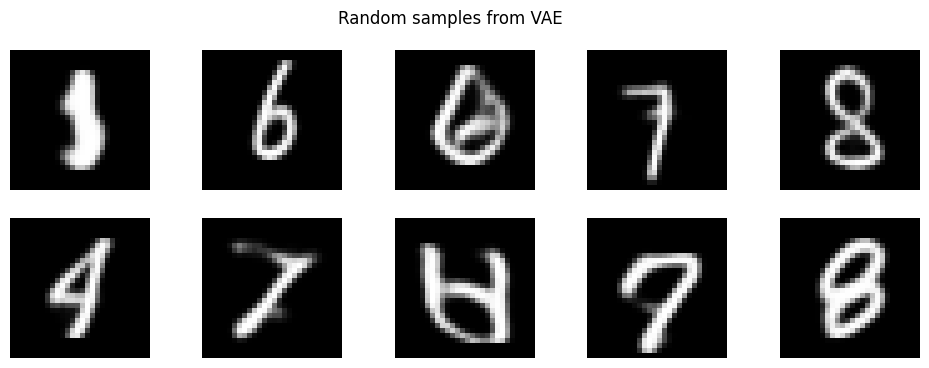

In [8]:
# Generate some random samples from the prior
z_sample = torch.randn(10, latent_dim, device=VAE.device)  # Create tensor on correct device

# Generate images from the random latent vectors
with torch.no_grad():
    x_rec = VAE.model.decode(z_sample)
    x_rec = torch.sigmoid(x_rec) # Apply sigmoid since using bernoulli VAE

# Plot the generated images
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    # Move tensor to CPU before plotting
    plt.imshow(x_rec[i].detach().cpu().reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle('Random samples from VAE')
plt.show()


### Load the BNN

First we import the relevant libraries and set the working directory

The cell below can be used to reload the BNN code if it has been changed

In [54]:
import importlib # Import the importlib module
import BNN

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

importlib.reload(BNN.models)  # Contains MLP
importlib.reload(BNN.wrapper) # Contains BNN_cat
importlib.reload(BNN.train)  # Contains train_BNN_classification

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

Next we load the BNN model

In [55]:
%matplotlib inline

input_dim = 784
width = 1200
depth = 2
output_dim = 10
model = MLP(input_dim, width, depth, output_dim, flatten_image=False)

N_train = 60000

lr = 1e-2

N_saves = 300
# N_saves = 5

BNN = BNN_cat(model, N_train, lr=lr, device=device)

save_dir = './my-saves/'
weights_path = save_dir + 'state_dicts.pt'

if os.path.exists(weights_path):
    BNN.load_weights(weights_path)
else:
    print(f"Weights file not found at: {weights_path}")



Net:
BNN categorical output
    Total params: 2.40M
Loading weight samples from ./my-saves/state_dicts.pt
File size: 2741.68 MB
Loaded object type: <class 'list'>
Number of weight samples: 300


### Load the original BNN

First we import the relevant libraries and set the working directory

The cell below can be used to reload the BNN code if it has been changed

In [ ]:
import importlib # Import the importlib module
import BNN

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

importlib.reload(BNN.models)  # Contains MLP
importlib.reload(BNN.wrapper) # Contains BNN_cat
importlib.reload(BNN.train)  # Contains train_BNN_classification

from BNN.models import MLP
from BNN.wrapper import BNN_cat
from BNN.train import train_BNN_classification

Next we load the BNN model

In [ ]:
%matplotlib inline

input_dim = 784
width = 1200
depth = 2
output_dim = 10
model = MLP(input_dim, width, depth, output_dim, flatten_image=False)

N_train = 60000

lr = 1e-2

N_saves = 300
# N_saves = 5

BNN = BNN_cat(model, N_train, lr=lr, device=device)

save_dir = '../original_saves/'
weights_path = save_dir + 'original_state_dicts.pkl'

if os.path.exists(weights_path):
    BNN.load_weights(weights_path)
else:
    print(f"Weights file not found at: {weights_path}")



Net:
BNN categorical output
    Total params: 2.40M
Weights file not found at: ../original_saves/original_state_dicts.pkl


### Load the datasets



In [56]:
if BNN.device.type != VAE.device.type:
    print(f"Device mismatch: BNN on {BNN.device}, VAE on {VAE.device}")

transform_train = transforms.Compose([
    transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

batch_size = 1024

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=BNN.device.type == 'cuda', num_workers=3)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=BNN.device.type == 'cuda', num_workers=3)

In [57]:
import numpy as np
from importlib import reload
import interpret.visualization_tools
reload(interpret.visualization_tools)
from interpret.visualization_tools import latent_project_MNIST


torch.cuda.empty_cache()

# tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train = \
#     latent_project_MNIST(BNN, VAE, dset=trainset, batch_size=1024, cuda=cuda, flatten_BNN=True, flatten_VAE=False)

te_aleatoric_vec, te_epistemic_vec, z_test, x_test, y_test = \
    latent_project_MNIST(BNN, VAE, dset=valset, batch_size=256, flatten_BNN=True, flatten_VAE=False)

torch.cuda.empty_cache()

te_uncertainty_vec = te_aleatoric_vec + te_epistemic_vec

uncert_idxs_sorted = np.flipud(np.argsort(te_aleatoric_vec + te_epistemic_vec))


In [58]:
def visualize_latent_points(VAE, z_test, num_points=10, figsize=(15,6)):
    """
    Visualize reconstructions from the first few latent points.

    Args:
        VAE: The trained VAE model
        z_test: Numpy array or Tensor of latent points to visualize
        num_points: Number of points to visualize (default=10)
        figsize: Size of the figure (default=(15,6))
    """
    # Ensure we don't try to show more points than we have
    num_points = min(num_points, z_test.shape[0])

    # Calculate grid dimensions
    num_rows = (num_points - 1) // 5 + 1  # 5 images per row
    num_cols = min(5, num_points)  # Maximum of 5 columns

    # Convert numpy array to torch tensor if necessary
    if isinstance(z_test, np.ndarray):
        z_test = torch.from_numpy(z_test).float()

    # Generate images from the latent vectors
    with torch.no_grad():
        x_rec = VAE.model.decode(z_test[:num_points].to(VAE.device))
        x_rec = torch.sigmoid(x_rec)  # Apply sigmoid since using bernoulli VAE

    # Plot the generated images
    plt.figure(figsize=figsize)
    for i in range(num_points):
        plt.subplot(num_rows, num_cols, i+1)
        # Move tensor to CPU before plotting
        plt.imshow(x_rec[i].detach().cpu().reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Reconstructions from test latent points')
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_latent_points(VAE, z_test, num_points=20)

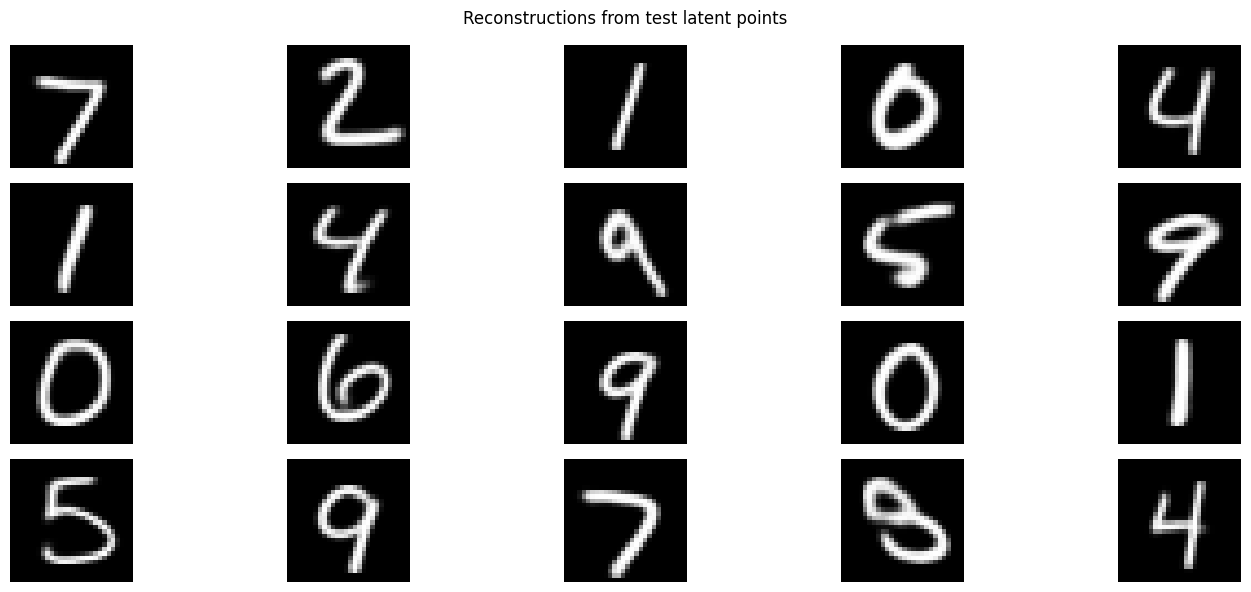

In [59]:
visualize_latent_points(VAE, z_test, num_points=20)

Text(0, 0.5, 'Uncertainty')

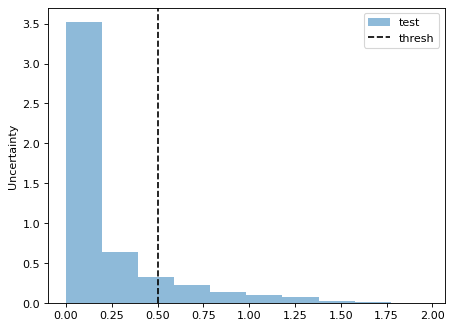

In [60]:
import matplotlib.pyplot as plt

H_thresh_MNIST = 0.5

plt.figure(dpi=80)
plt.hist(te_uncertainty_vec, density=True, alpha=0.5, label='test')
plt.axvline(x=H_thresh_MNIST, color='k', linestyle='--', label='thresh')
plt.legend()
plt.ylabel('Uncertainty')

In [61]:
Nbatch = 40
z_init_batch = z_test[uncert_idxs_sorted[:Nbatch]]
x_init_batch = x_test[uncert_idxs_sorted[:Nbatch]]
y_init_batch = y_test[uncert_idxs_sorted[:Nbatch]]

## Test calibration of BNN


In [ ]:
from sklearn.calibration import calibration_curve

def plot_reliability_diagram(y_true, pred_classes, max_probs, n_bins=10, model_name='BNN', ax=None):
    """
    Plot reliability diagram for multiclass classification
    y_true: true labels
    pred_classes: predicted classes
    max_probs: confidence scores (maximum probability)
    ax: matplotlib axes to plot on
    """
    if ax is None:
        ax = plt.gca()

    # Convert y_true to 0 and 1 for binary classification
    y_true_binary = (y_true == pred_classes).astype(int)

    prob_true, prob_pred = calibration_curve(y_true_binary,
                                           max_probs,
                                           n_bins=n_bins,
                                           strategy='uniform')

    ax.plot(prob_pred, prob_true, marker='o', label=model_name)
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Observed Frequency')
    ax.set_title('Reliability Diagram')
    ax.legend()

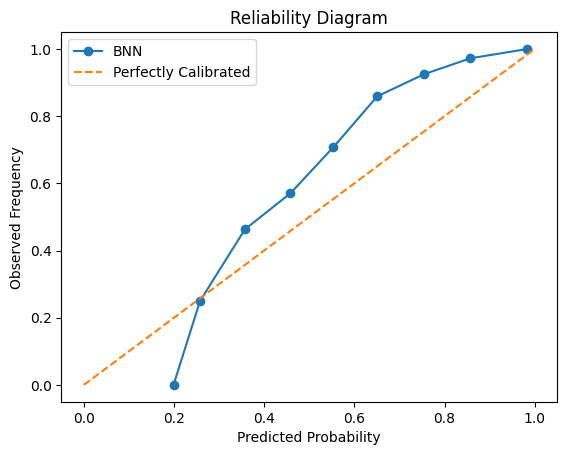

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from src.utils import MNIST_mean_std_norm

# Get BNN predictions on test set
x_test_processed = MNIST_mean_std_norm(torch.tensor(x_test).reshape(x_test.shape[0], -1))
# Move tensor to the same device as BNN
x_test_processed = x_test_processed.to(BNN.device)
# Use sample_predict instead of direct call
probs = BNN.sample_predict(x_test_processed, Nsamples=0, grad=False)

# For multiclass case, we'll use the maximum probability as confidence
max_probs_BNN = probs.mean(dim=0).max(dim=1)[0].detach().cpu().numpy()
pred_classes = probs.mean(dim=0).argmax(dim=1).detach().cpu().numpy()

# Plot calibration curve
plot_reliability_diagram(y_test, pred_classes, max_probs_BNN)

Epoch 1, Loss: 0.2576, Test Accuracy: 98.39%
Epoch 2, Loss: 0.0634, Test Accuracy: 99.04%
Epoch 3, Loss: 0.0429, Test Accuracy: 99.28%
Epoch 4, Loss: 0.0373, Test Accuracy: 99.32%
Epoch 5, Loss: 0.0293, Test Accuracy: 99.22%
Epoch 6, Loss: 0.0262, Test Accuracy: 99.26%
Epoch 7, Loss: 0.0224, Test Accuracy: 99.41%
Epoch 8, Loss: 0.0201, Test Accuracy: 99.37%
Epoch 9, Loss: 0.0177, Test Accuracy: 99.35%
Epoch 10, Loss: 0.0175, Test Accuracy: 99.32%


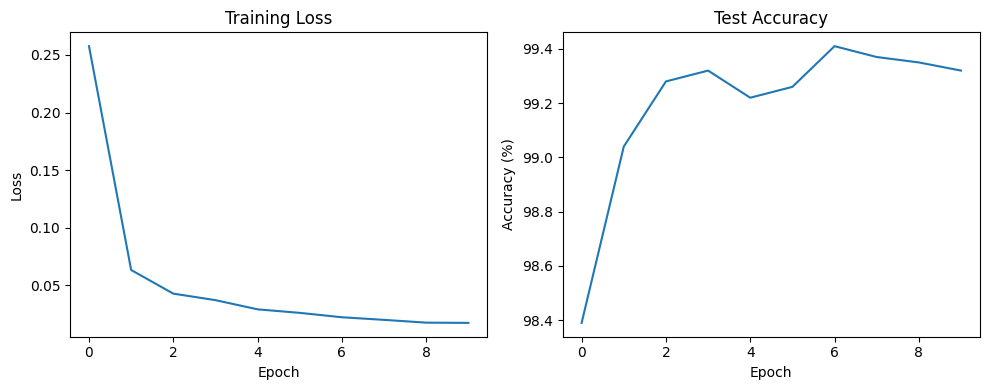

In [ ]:
# Train a regular CNN for comparison
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Match BNN_cat architecture
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)  # 28x28 -> 28x28
        self.pool1 = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # 14x14 -> 14x14
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)  # 14x14 -> 14x14
        self.pool2 = nn.MaxPool2d(2, 2)  # 14x14 -> 7x7

        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Reshape to [batch, channels, height, width]

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout(x)

        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Initialize model and move to same device as BNN
cnn = SimpleCNN().to(BNN.device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(cnn.parameters())

# Training loop
n_epochs = 10
batch_size = 128

# Create DataLoaders with num_workers=0 to avoid multiprocessing issues
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                      shuffle=False, num_workers=0)

# Train using the DataLoader
train_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    cnn.train()
    running_loss = 0.0

    # Train on batches from trainloader
    for batch_x, batch_y in trainloader:
        batch_x = batch_x.to(BNN.device)
        batch_y = batch_y.to(BNN.device)

        optimizer.zero_grad()
        outputs = cnn(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluate on validation set
    cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in valloader:
            batch_x = batch_x.to(BNN.device)
            batch_y = batch_y.to(BNN.device)
            outputs = cnn(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = 100 * correct / total
    train_losses.append(running_loss/len(trainloader))
    test_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, Test Accuracy: {accuracy:.2f}%')

# Plot training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

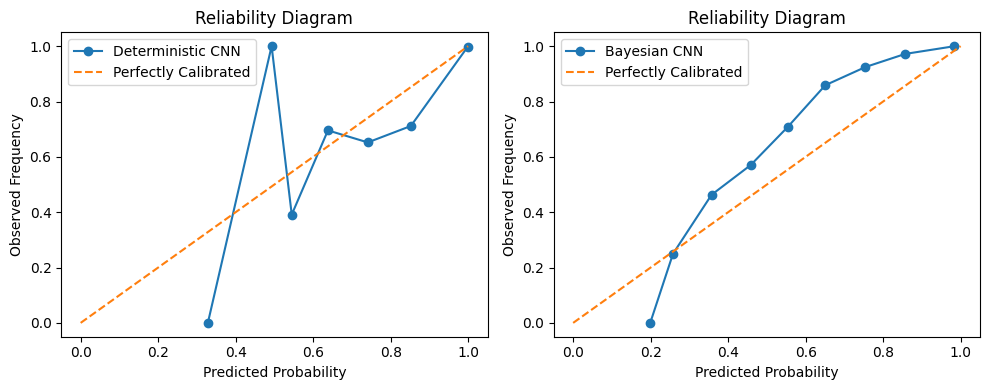

In [ ]:
# Get predictions and confidence scores from trained CNN
cnn.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in valloader:
        batch_x = batch_x.to(BNN.device)
        outputs = cnn(batch_x)
        probs = F.softmax(outputs, dim=1)
        max_probs, predicted = torch.max(probs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(max_probs.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot on the first subplot
plot_reliability_diagram(all_labels, all_preds, all_probs, n_bins=10,
                        model_name='Deterministic CNN', ax=ax1)

# Plot on the second subplot
plot_reliability_diagram(y_test, pred_classes, max_probs_BNN,
                        model_name='Bayesian CNN', ax=ax2)

plt.tight_layout()
plt.show()


## Old code for CLUE


In [ ]:
print(x_init_batch.shape)

In [ ]:
from interpret.CLUE import CLUE
import importlib
import interpret.CLUE
importlib.reload(interpret.CLUE)
from interpret.CLUE import CLUE

from src.utils import Ln_distance

# batch_size = 10

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]
distance_weight = 25 / x_dim



# z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec = \
# CLUE.batch_optimise(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
#                       prior_weight=0, distance_weight=distance_weight,
#                  latent_L2_weight=0, prediction_similarity_weight=0,
#                  lr=1e-1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
#                       flatten_BNN=True,
#                  regression=False, cuda=True, batch_size=batch_size, min_steps=3, max_steps=25, n_early_stop=3)


CLUE_explainer = CLUE(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
                      prior_weight=0, distance_weight=distance_weight,
                 latent_L2_weight=0, prediction_similarity_weight=0,
                 lr=1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
                      flatten_BNN=True,
                 regression=False, cuda=False)

torch.autograd.set_detect_anomaly(False)

# clue_instance.optimizer = SGD(self.trainable_params, lr=lr, momentum=0.5, nesterov=True)
z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
    min_steps=3, max_steps=20, n_early_stop=3 )

fig, axes = plt.subplots(1, 3, dpi=130)
axes[0].plot(cost_vec.mean(axis=1))
axes[0].set_title('mean Cost')
axes[0].set_xlabel('iterations')

axes[1].plot(uncertainty_vec.mean(axis=1))
axes[1].set_title('mean Total Entropy')
axes[1].set_xlabel('iterations')

axes[2].plot(dist_vec.mean(axis=1))
axes[2].set_title('mean Ln Cost')
axes[2].set_xlabel('iterations')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

In [ ]:
# Verify device placement
print(f"BNN device: {BNN.device}")
print(f"VAE device: {VAE.device}")

# Test CLUE
### Run CLUE


In [62]:
import importlib
import interpret.CLUE
importlib.reload(interpret.CLUE)
from interpret.CLUE import CLUE
from src.utils import Ln_distance

# batch_size = 10

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]
distance_weight = 25 / x_dim


# z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec = \
# CLUE.batch_optimise(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
#                       prior_weight=0, distance_weight=distance_weight,
#                  latent_L2_weight=0, prediction_similarity_weight=0,
#                  lr=1e-1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
#                       flatten_BNN=True,
#                  regression=False, cuda=True, batch_size=batch_size, min_steps=3, max_steps=25, n_early_stop=3)

# Convert input tensors to device
# x_init_batch = x_init_batch.to(device)
# z_init_batch = z_init_batch.to(device) if z_init_batch is not None else None


CLUE_explainer = CLUE(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
                      prior_weight=0, distance_weight=distance_weight,
                 latent_L2_weight=0, prediction_similarity_weight=0,
                 lr=1e-1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
                      flatten_BNN=True,
                 regression=False)

CLUE_explainer.gradient_check()

self.z.requires_grad:  True


TypeError: CLUE.get_objective() missing 4 required positional arguments: 'total_uncertainty', 'aleatoric_uncertainty', 'epistemic_uncertainty', and 'preds'

In [50]:
import importlib
import interpret.CLUE
importlib.reload(interpret.CLUE)
from interpret.CLUE import CLUE
from src.utils import Ln_distance

# batch_size = 10

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]
distance_weight = 25 / x_dim


# z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec = \
# CLUE.batch_optimise(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
#                       prior_weight=0, distance_weight=distance_weight,
#                  latent_L2_weight=0, prediction_similarity_weight=0,
#                  lr=1e-1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
#                       flatten_BNN=True,
#                  regression=False, cuda=True, batch_size=batch_size, min_steps=3, max_steps=25, n_early_stop=3)

# Convert input tensors to device
# x_init_batch = x_init_batch.to(device)
# z_init_batch = z_init_batch.to(device) if z_init_batch is not None else None


CLUE_explainer = CLUE(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
                      prior_weight=0, distance_weight=distance_weight,
                 latent_L2_weight=0, prediction_similarity_weight=0,
                 lr=1e-1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
                      flatten_BNN=True,
                 regression=False)

CLUE_explainer.simple_optimise(5)

self.z.requires_grad:  True
Step 0, Loss: 28.720827102661133, z: tensor([[ 9.4122e-02, -1.3563e+00,  1.5211e+00, -4.4828e-01, -9.0149e-01,
          7.0867e-02,  9.5164e-02, -5.3712e-01,  1.8902e+00, -5.3108e-01,
         -1.0042e-01, -7.1961e-01, -6.4240e-01,  3.7291e-01, -2.1064e+00,
         -3.4656e-01, -4.5840e-01,  1.4628e+00, -8.8936e-02, -1.6996e+00],
        [ 8.8619e-02, -1.8542e+00,  1.0313e+00,  6.8279e-01, -7.1704e-01,
          7.8569e-01, -4.0399e-02,  4.8071e-01,  1.2241e+00,  1.3990e+00,
         -5.3466e-01,  1.4155e+00,  3.3964e-01, -1.9842e+00, -2.2223e-01,
          4.3772e-01,  4.4279e-01, -1.8964e+00, -7.2028e-01,  5.1535e-02],
        [ 9.2021e-02, -1.1389e+00,  1.0661e+00,  1.2503e+00, -8.1497e-02,
         -2.9212e-02,  1.7320e+00,  5.9420e-01, -1.3430e+00,  1.0651e+00,
         -2.2235e-01,  1.7286e+00, -1.6485e+00, -8.5294e-01,  8.9661e-01,
          1.0002e+00,  9.2010e-01, -6.2241e-01,  6.8863e-01,  5.9968e-01],
        [ 8.4963e-02, -4.2449e-01,  4.9226e-

In [63]:
import importlib
import interpret.CLUE
importlib.reload(interpret.CLUE)
from interpret.CLUE import CLUE
from src.utils import Ln_distance

# batch_size = 10

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]
distance_weight = 25 / x_dim


# z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec = \
# CLUE.batch_optimise(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
#                       prior_weight=0, distance_weight=distance_weight,
#                  latent_L2_weight=0, prediction_similarity_weight=0,
#                  lr=1e-1,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
#                       flatten_BNN=True,
#                  regression=False, cuda=True, batch_size=batch_size, min_steps=3, max_steps=25, n_early_stop=3)

# Convert input tensors to device
# x_init_batch = x_init_batch.to(device)
# z_init_batch = z_init_batch.to(device) if z_init_batch is not None else None




CLUE_explainer = CLUE(VAE, BNN, x_init_batch, uncertainty_weight=1, aleatoric_weight=0, epistemic_weight=0,
                      prior_weight=0, distance_weight=distance_weight,
                 latent_L2_weight=0, prediction_similarity_weight=0,
                 lr=1e-3,  cond_mask=None, distance_metric=dist, z_init=z_init_batch, norm_MNIST=True,
                      flatten_BNN=True,
                 regression=False)

# clue_instance.optimizer = SGD(self.trainable_params, lr=lr, momentum=0.5, nesterov=True)
z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
     min_steps=3, max_steps=50, n_early_stop=40, std=0.8 )

fig, axes = plt.subplots(1, 3, dpi=130)
axes[0].plot(cost_vec.mean(axis=1))
axes[0].set_title('mean Cost')
axes[0].set_xlabel('iterations')

axes[1].plot(uncertainty_vec.mean(axis=1))
axes[1].set_title('mean Total Entropy')
axes[1].set_xlabel('iterations')

axes[2].plot(dist_vec.mean(axis=1))
axes[2].set_title('mean Ln Cost')
axes[2].set_xlabel('iterations')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)


self.z.requires_grad:  True
randomised z:  0.8
toBNN.requires_grad:  True
probs.requires_grad:  True


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
    self._run_once()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
    handle._run()
  File "/usr/lib/python3.1

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1200, 10]], which is output 0 of AsStridedBackward0, is at version 12342; expected version 12341 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

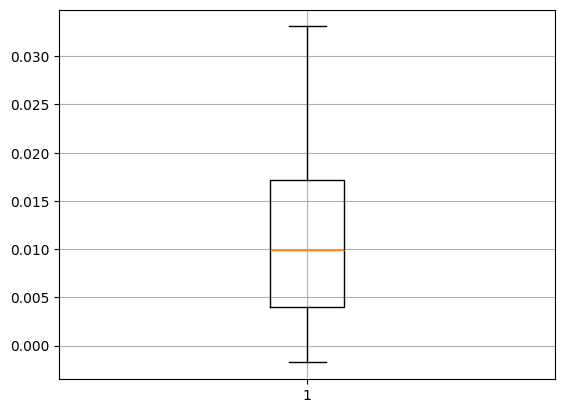

In [30]:
delta_x = np.abs(x_init_batch - x_vec[-1]).sum(axis=(1,2,3))
delta_H = te_uncertainty_vec[uncert_idxs_sorted[:Nbatch]] - uncertainty_vec[-1]

ratio = delta_H / delta_x


plt.figure(dpi=100)
plt.boxplot([ratio])
plt.grid()
ax = plt.gca()


### Visualise CLUEs

original aleatoric: 1.567 epistemic 0.401
original predictions [[1 9 2 7 8 4 5 3 6 0]]
explanation aleatoric: 1.301 epistemic 0.313
original predictions [[5 2 7 9 1 0 6 8 3 4]]
0


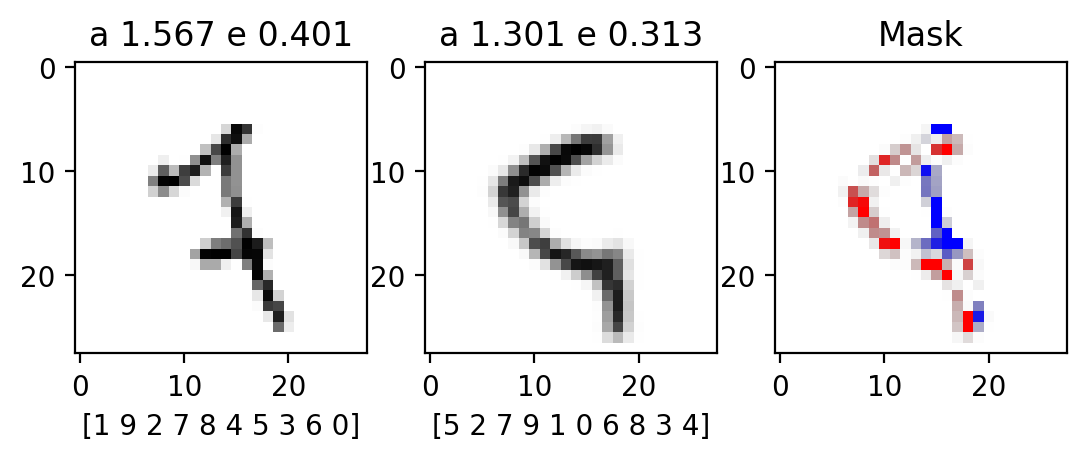

original aleatoric: 1.422 epistemic 0.484
original predictions [[2 7 9 5 8 4 0 3 6 1]]
explanation aleatoric: 1.158 epistemic 0.284
original predictions [[5 0 7 4 9 2 8 6 3 1]]
1


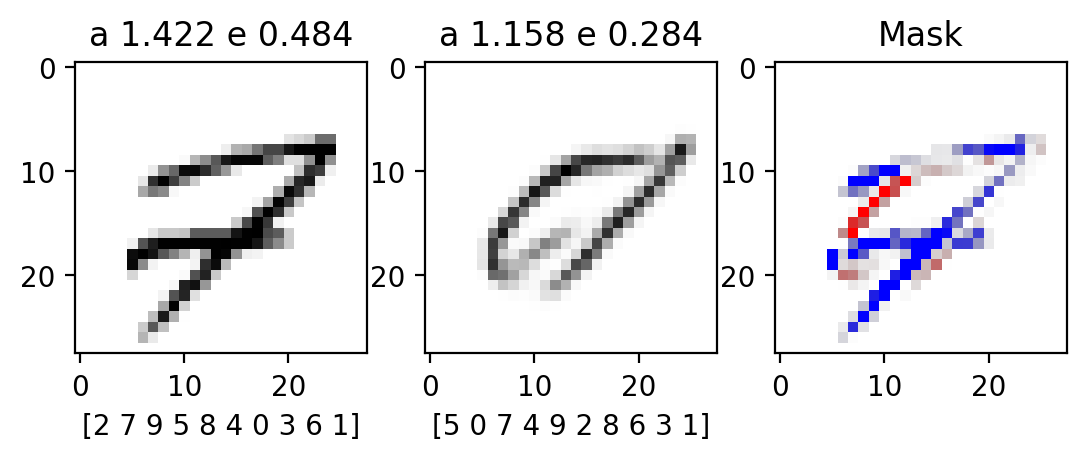

original aleatoric: 1.410 epistemic 0.485
original predictions [[5 8 2 4 1 3 0 6 7 9]]
explanation aleatoric: 1.469 epistemic 0.472
original predictions [[5 2 0 8 3 6 4 7 1 9]]
2


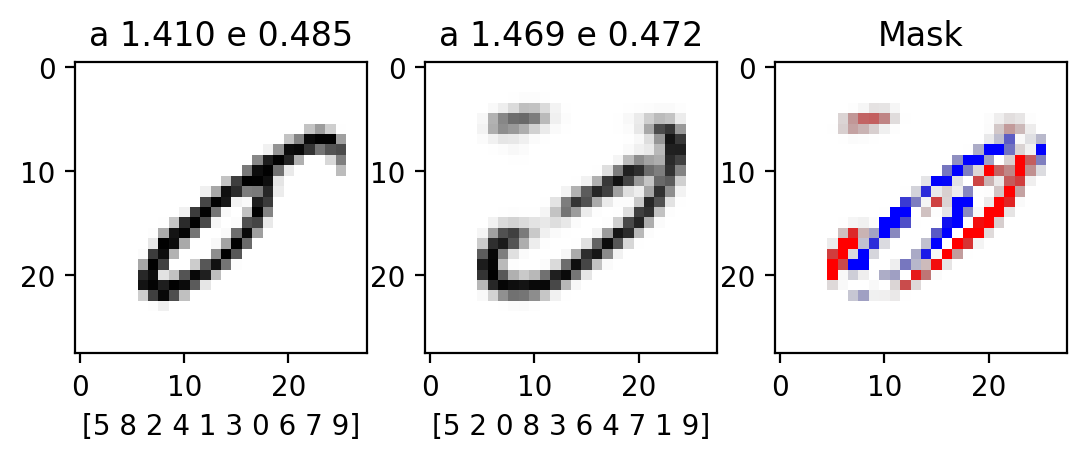

original aleatoric: 1.397 epistemic 0.493
original predictions [[2 8 9 3 6 5 0 4 7 1]]
explanation aleatoric: 0.301 epistemic 0.127
original predictions [[0 6 9 7 2 5 8 4 1 3]]
3


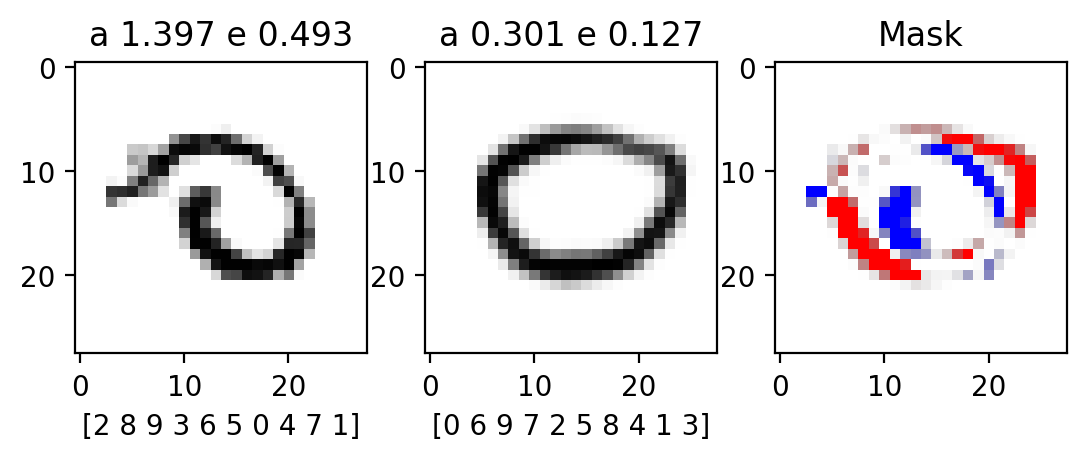

original aleatoric: 1.385 epistemic 0.473
original predictions [[4 2 9 3 8 5 1 6 7 0]]
explanation aleatoric: 0.479 epistemic 0.094
original predictions [[1 3 2 8 9 7 5 4 6 0]]
4


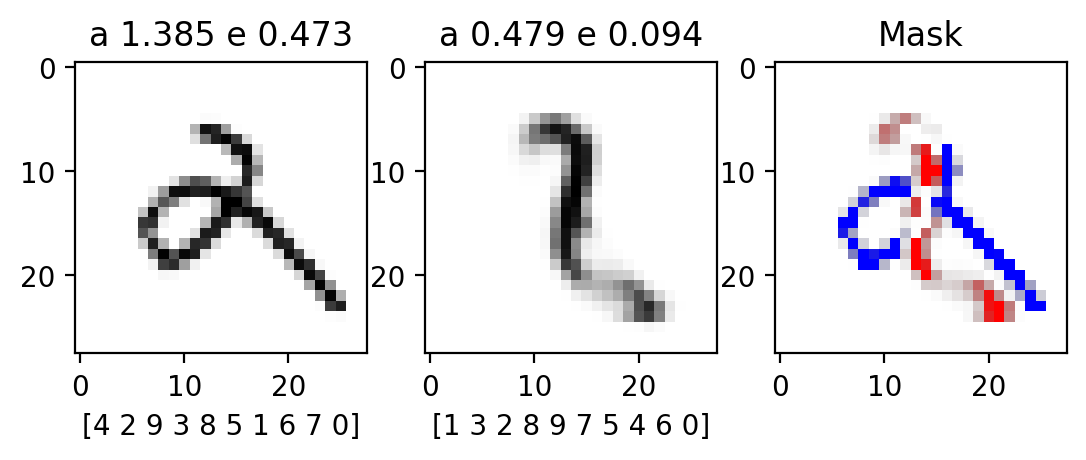

original aleatoric: 1.391 epistemic 0.436
original predictions [[9 8 1 3 7 4 5 6 2 0]]
explanation aleatoric: 0.992 epistemic 0.283
original predictions [[9 7 4 8 3 1 5 2 6 0]]
5


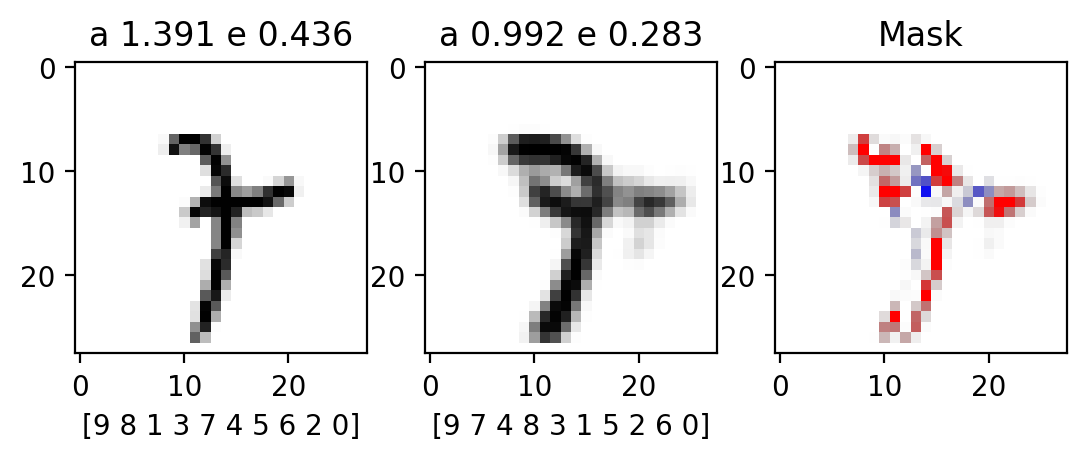

original aleatoric: 1.299 epistemic 0.527
original predictions [[3 5 4 0 6 2 8 9 1 7]]
explanation aleatoric: 1.115 epistemic 0.291
original predictions [[5 4 0 6 7 9 2 8 3 1]]
6


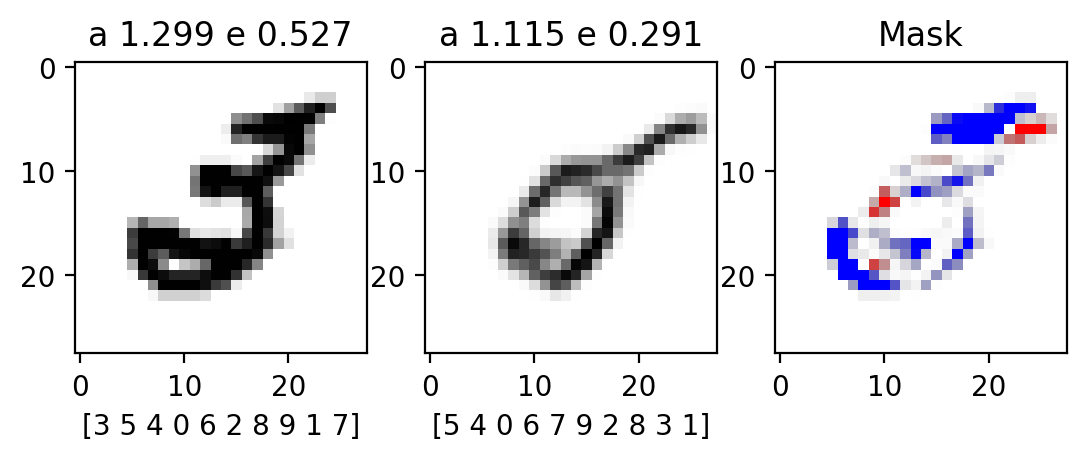

original aleatoric: 1.388 epistemic 0.432
original predictions [[0 3 6 5 7 2 4 1 9 8]]
explanation aleatoric: 1.281 epistemic 0.357
original predictions [[7 3 5 0 9 4 6 1 2 8]]
7


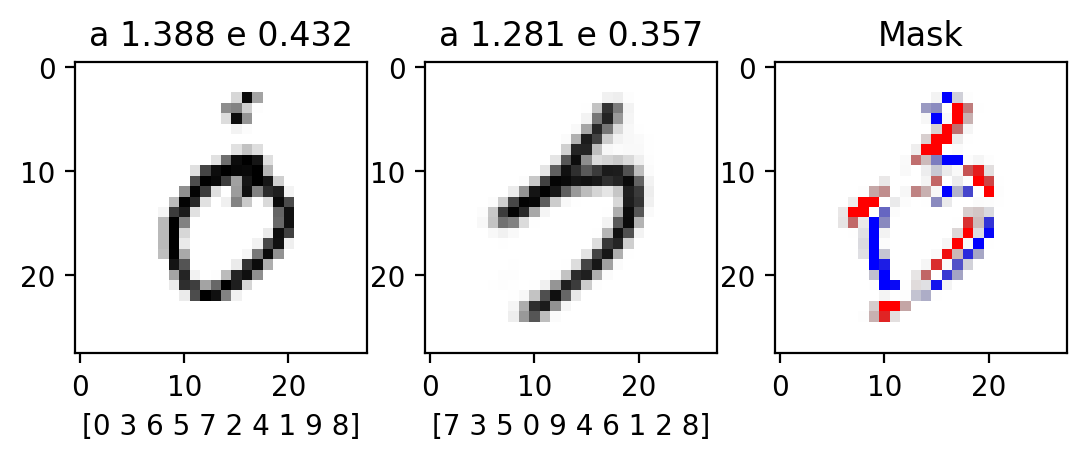

original aleatoric: 1.270 epistemic 0.470
original predictions [[8 4 3 2 5 9 7 1 6 0]]
explanation aleatoric: 0.398 epistemic 0.069
original predictions [[1 5 8 3 4 7 2 9 6 0]]
8


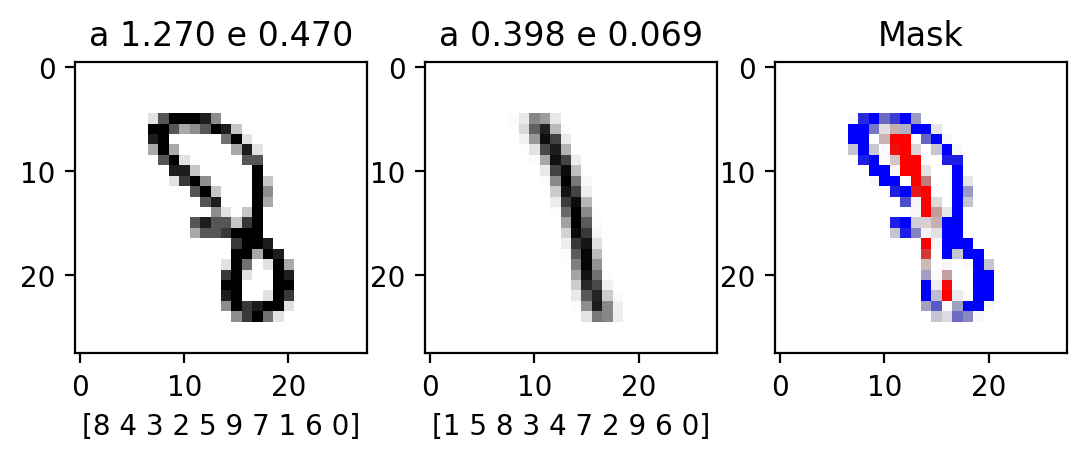

original aleatoric: 1.378 epistemic 0.350
original predictions [[9 3 4 8 5 7 1 2 0 6]]
explanation aleatoric: 0.983 epistemic 0.269
original predictions [[4 0 5 9 6 2 8 3 7 1]]
9


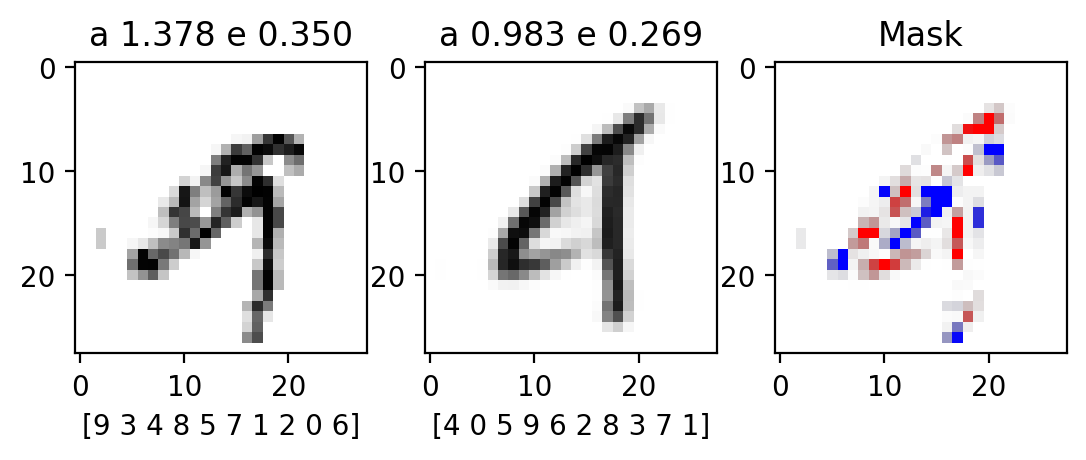

original aleatoric: 1.226 epistemic 0.492
original predictions [[8 1 7 2 3 9 5 4 0 6]]
explanation aleatoric: 0.397 epistemic 0.159
original predictions [[8 3 9 7 2 5 1 0 4 6]]
10


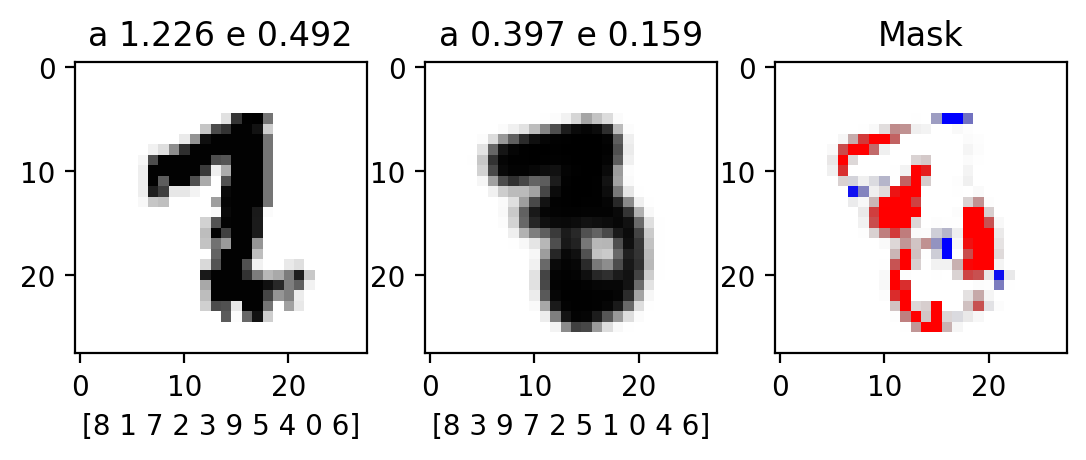

original aleatoric: 1.169 epistemic 0.546
original predictions [[0 4 1 6 7 2 5 3 8 9]]
explanation aleatoric: 0.294 epistemic 0.087
original predictions [[7 9 4 8 2 5 3 0 1 6]]
11


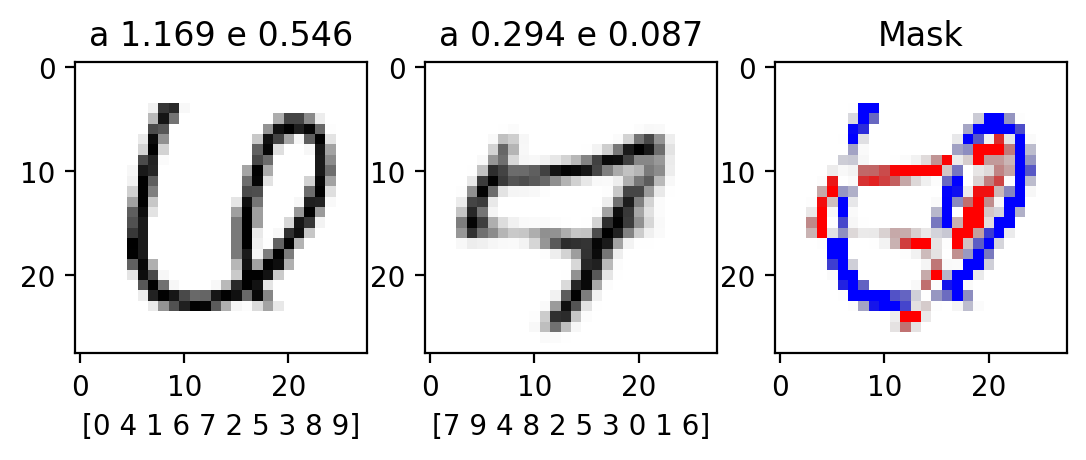

original aleatoric: 1.240 epistemic 0.464
original predictions [[8 6 1 5 2 3 0 9 4 7]]
explanation aleatoric: 0.426 epistemic 0.156
original predictions [[8 2 6 5 4 3 9 0 1 7]]
12


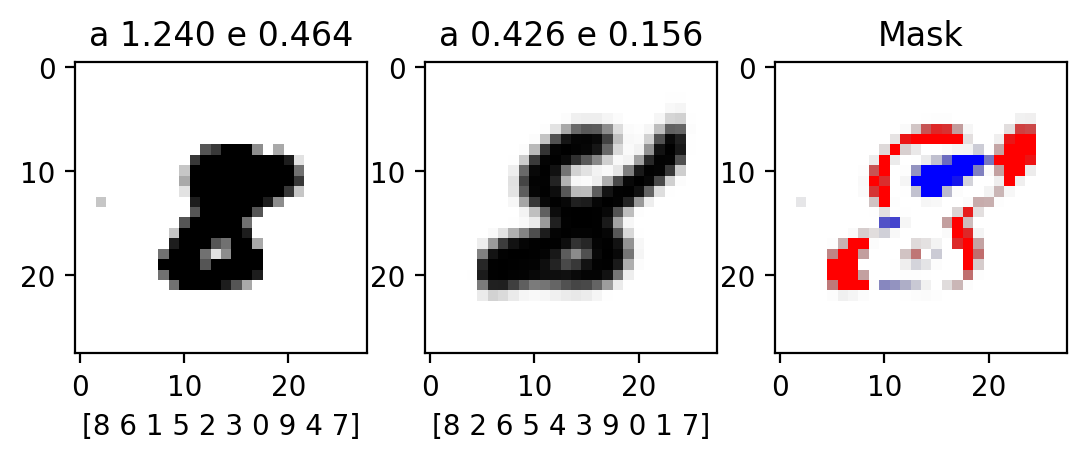

original aleatoric: 1.350 epistemic 0.349
original predictions [[2 7 1 3 8 5 6 9 4 0]]
explanation aleatoric: 0.440 epistemic 0.076
original predictions [[1 5 3 8 9 7 4 2 6 0]]
13


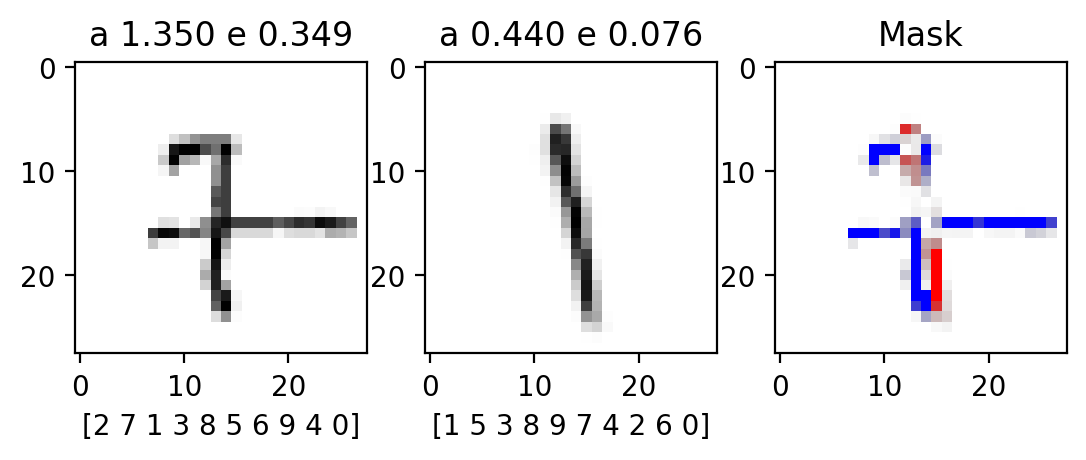

original aleatoric: 1.307 epistemic 0.382
original predictions [[4 8 7 2 1 3 9 6 5 0]]
explanation aleatoric: 0.728 epistemic 0.178
original predictions [[7 1 3 9 2 8 5 4 6 0]]
14


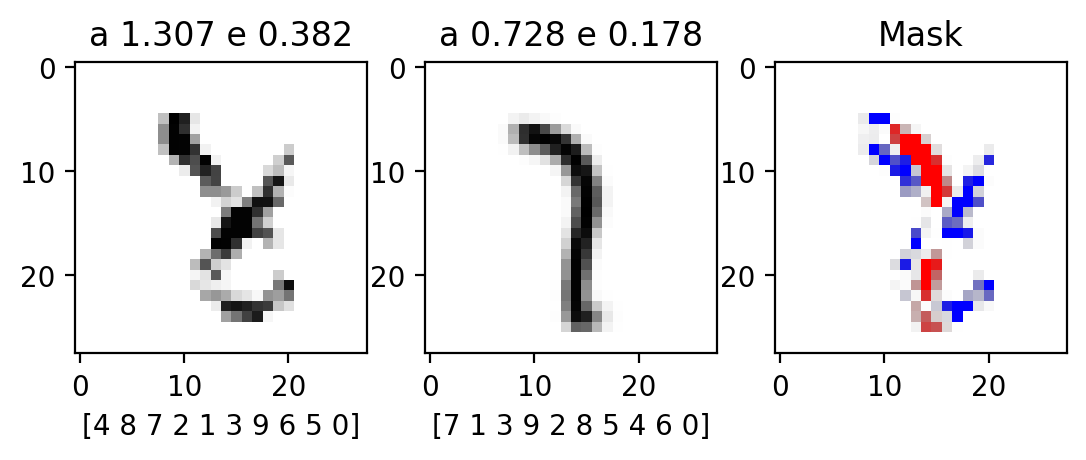

original aleatoric: 1.277 epistemic 0.407
original predictions [[9 8 7 4 5 1 3 0 6 2]]
explanation aleatoric: 0.936 epistemic 0.248
original predictions [[7 1 9 8 3 5 4 2 0 6]]
15


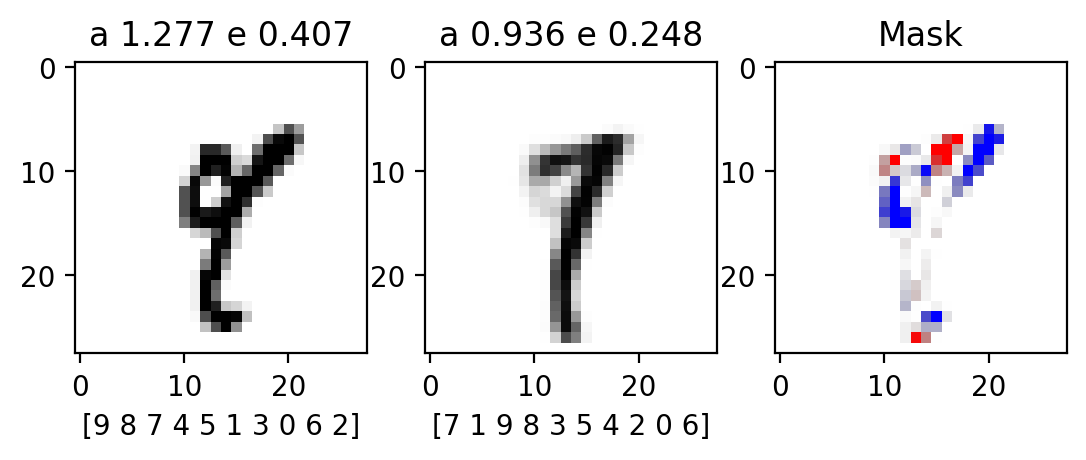

original aleatoric: 1.261 epistemic 0.422
original predictions [[7 1 3 9 8 2 4 6 5 0]]
explanation aleatoric: 0.846 epistemic 0.242
original predictions [[3 1 9 8 7 4 5 2 6 0]]
16


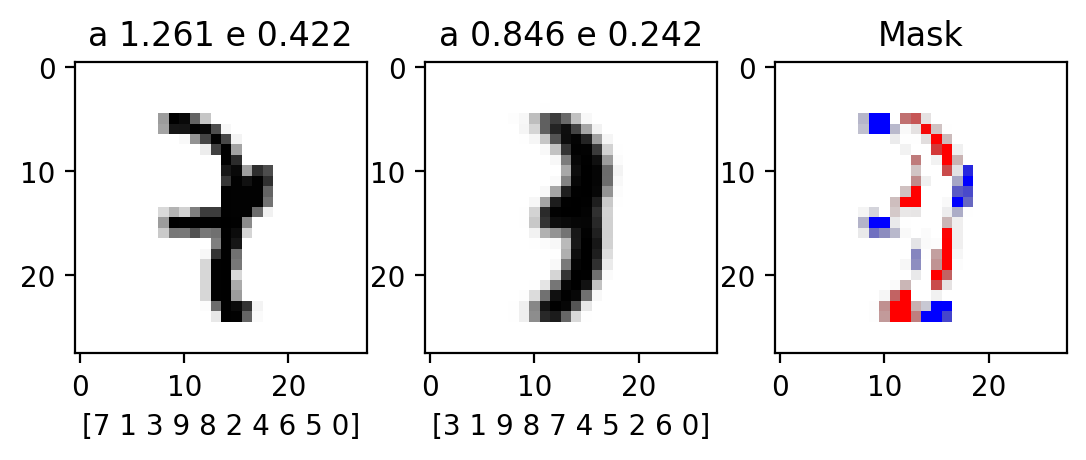

original aleatoric: 1.276 epistemic 0.400
original predictions [[8 1 4 2 5 9 7 6 3 0]]
explanation aleatoric: 0.996 epistemic 0.280
original predictions [[8 6 5 2 1 0 9 4 7 3]]
17


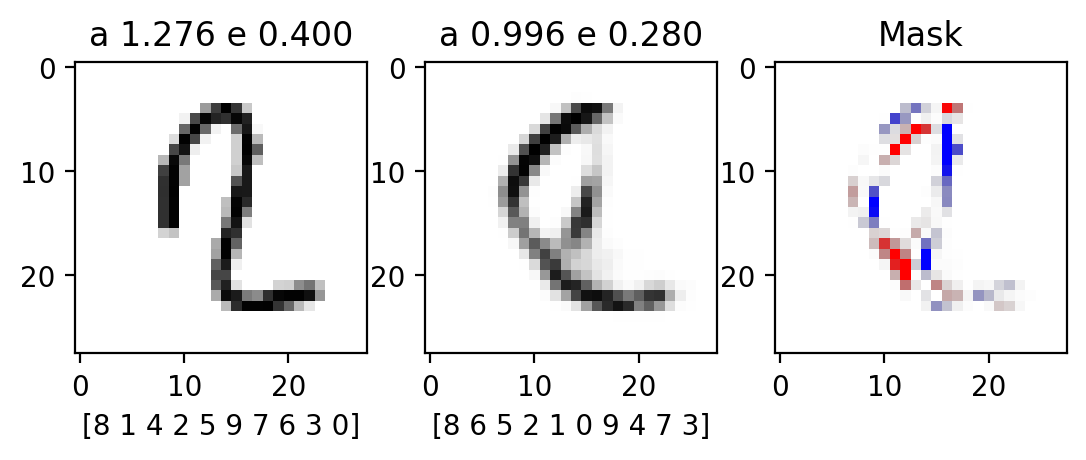

original aleatoric: 1.350 epistemic 0.320
original predictions [[3 5 9 7 4 8 1 2 6 0]]
explanation aleatoric: 1.292 epistemic 0.242
original predictions [[9 3 5 8 4 7 1 2 0 6]]
18


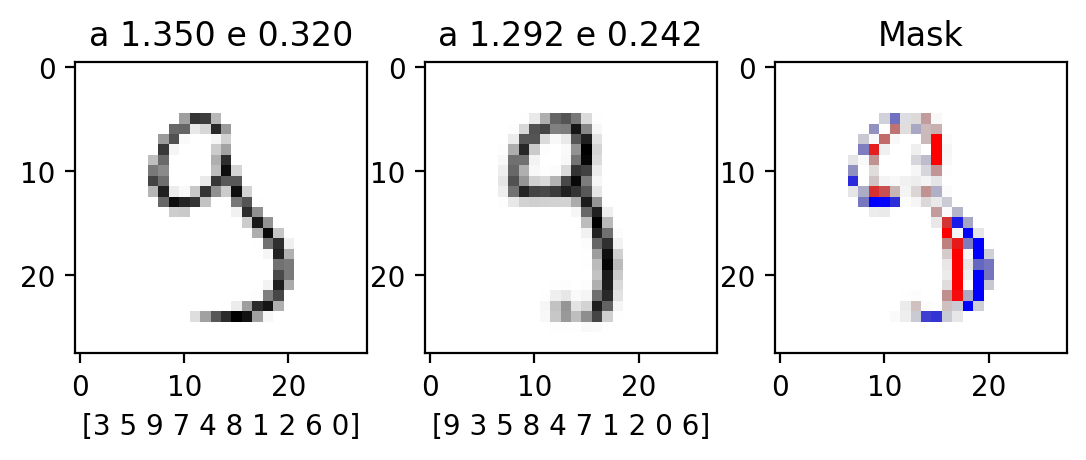

original aleatoric: 1.292 epistemic 0.376
original predictions [[3 9 5 8 0 1 2 7 4 6]]
explanation aleatoric: 1.017 epistemic 0.266
original predictions [[8 3 5 9 1 0 4 2 7 6]]
19


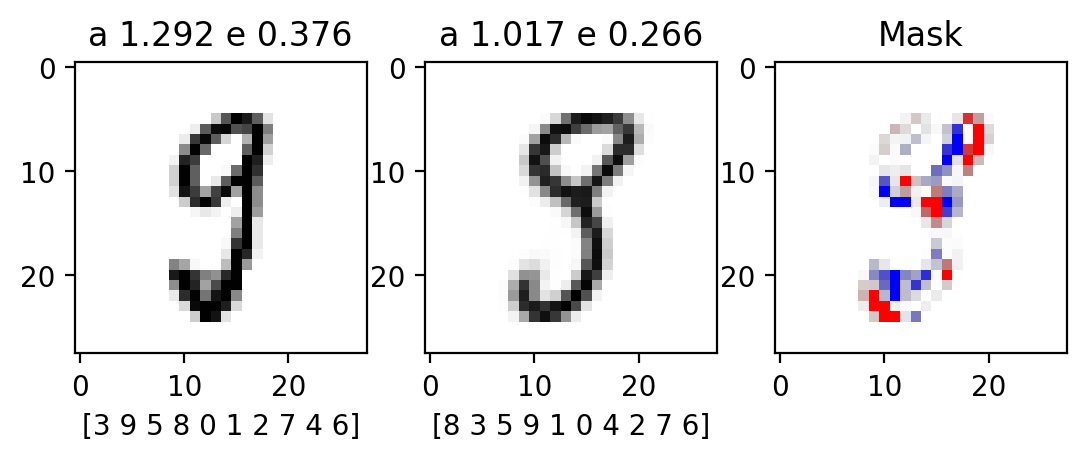

original aleatoric: 1.287 epistemic 0.363
original predictions [[5 3 4 9 8 1 7 6 2 0]]
explanation aleatoric: 0.424 epistemic 0.083
original predictions [[1 3 8 4 5 9 2 7 6 0]]
20


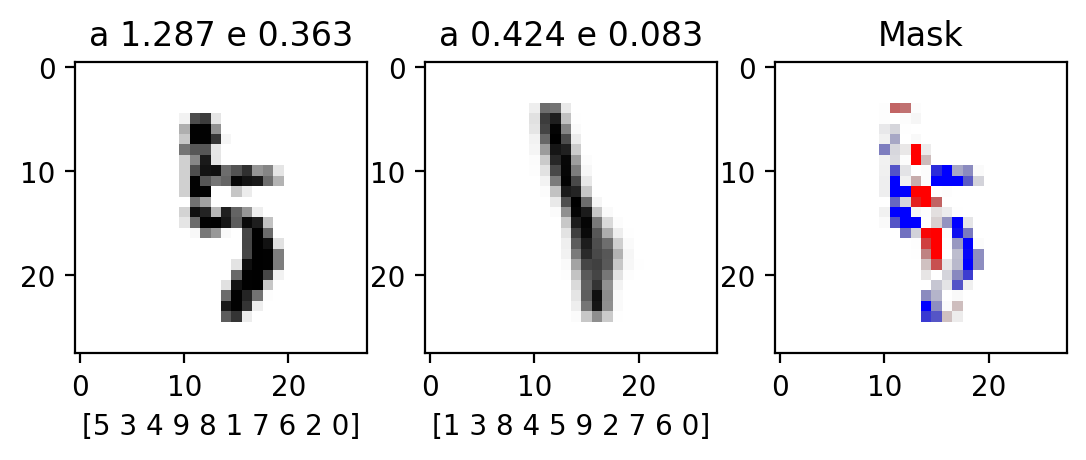

original aleatoric: 1.291 epistemic 0.358
original predictions [[1 8 9 4 7 3 2 6 5 0]]
explanation aleatoric: 0.409 epistemic 0.107
original predictions [[8 1 2 6 3 9 4 7 0 5]]
21


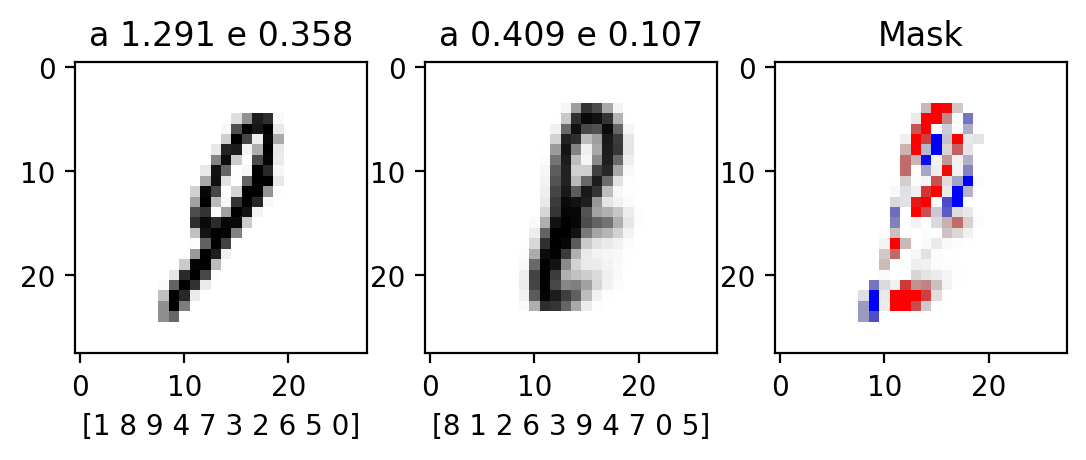

original aleatoric: 1.187 epistemic 0.459
original predictions [[9 5 8 4 6 3 7 0 2 1]]
explanation aleatoric: 0.769 epistemic 0.254
original predictions [[8 6 5 0 9 4 2 3 1 7]]
22


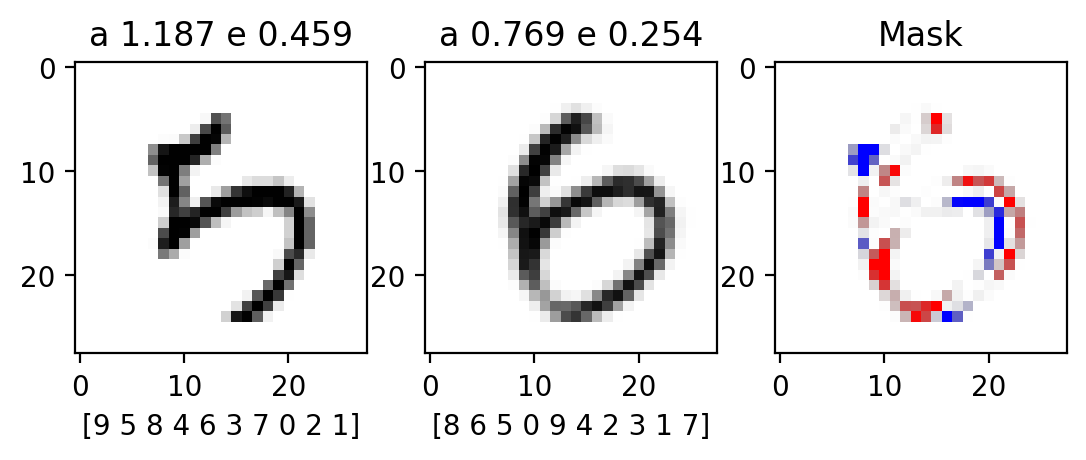

original aleatoric: 1.179 epistemic 0.455
original predictions [[4 0 6 7 2 1 9 8 5 3]]
explanation aleatoric: 0.536 epistemic 0.205
original predictions [[6 4 2 0 7 9 8 1 3 5]]
23


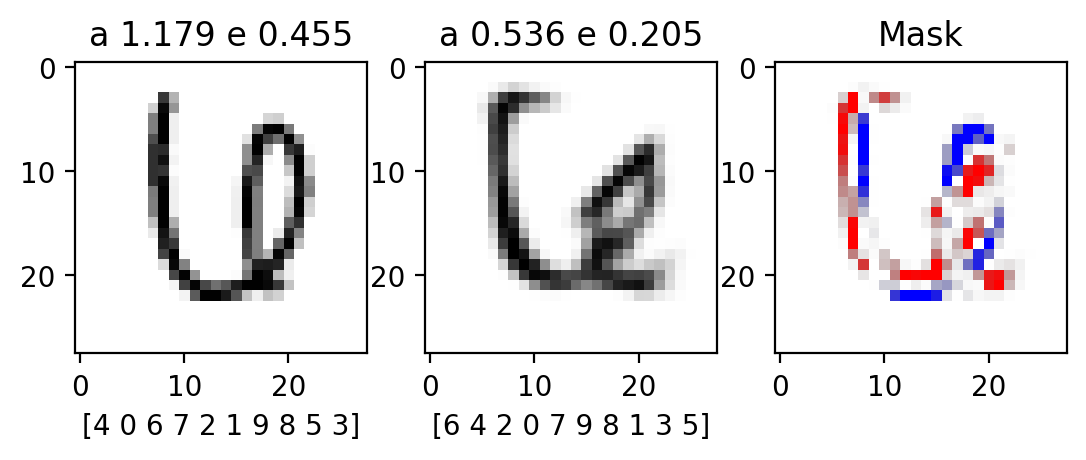

original aleatoric: 1.241 epistemic 0.381
original predictions [[3 8 5 2 1 9 7 0 4 6]]
explanation aleatoric: 0.593 epistemic 0.199
original predictions [[2 3 8 7 9 4 5 0 6 1]]
24


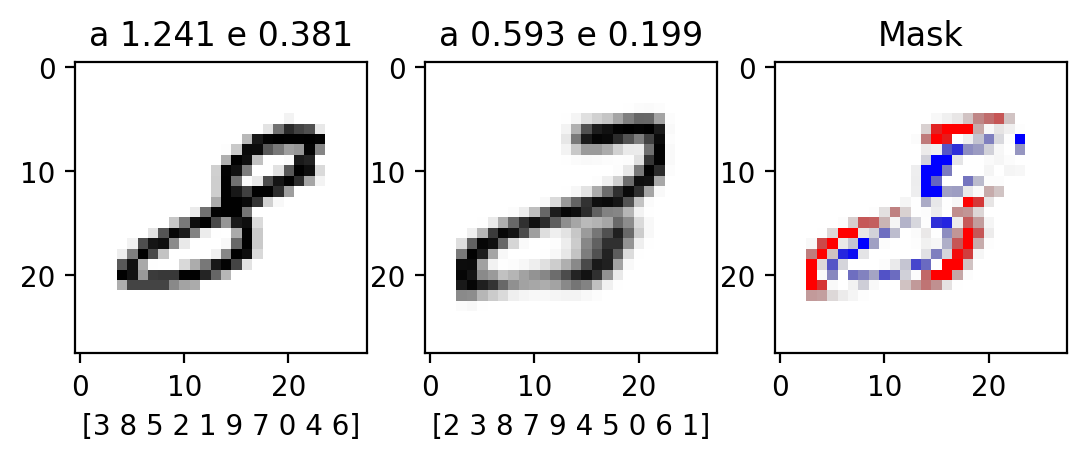

original aleatoric: 1.102 epistemic 0.518
original predictions [[5 2 3 6 8 1 7 4 0 9]]
explanation aleatoric: 0.943 epistemic 0.366
original predictions [[5 2 3 7 1 0 8 6 9 4]]
25


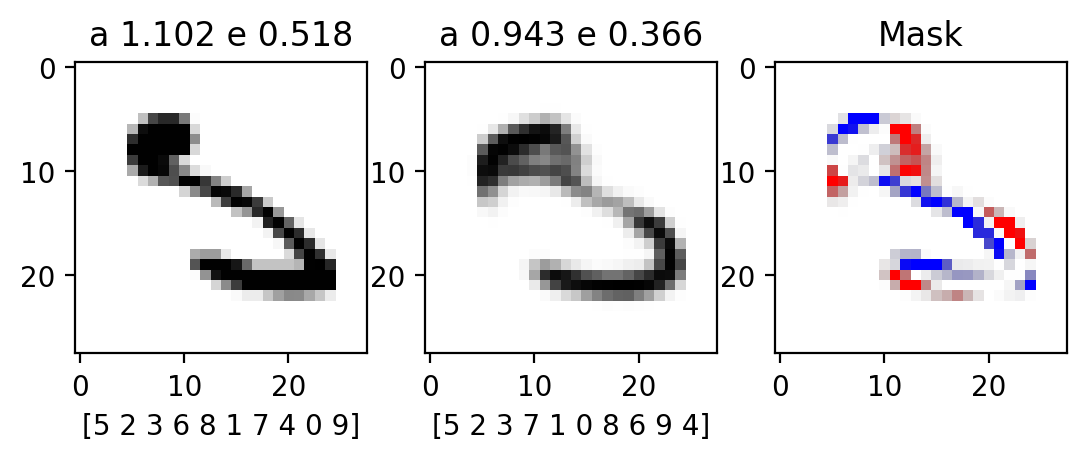

original aleatoric: 1.252 epistemic 0.368
original predictions [[8 2 7 5 9 0 3 6 4 1]]
explanation aleatoric: 0.538 epistemic 0.195
original predictions [[4 8 6 9 0 7 5 2 1 3]]
26


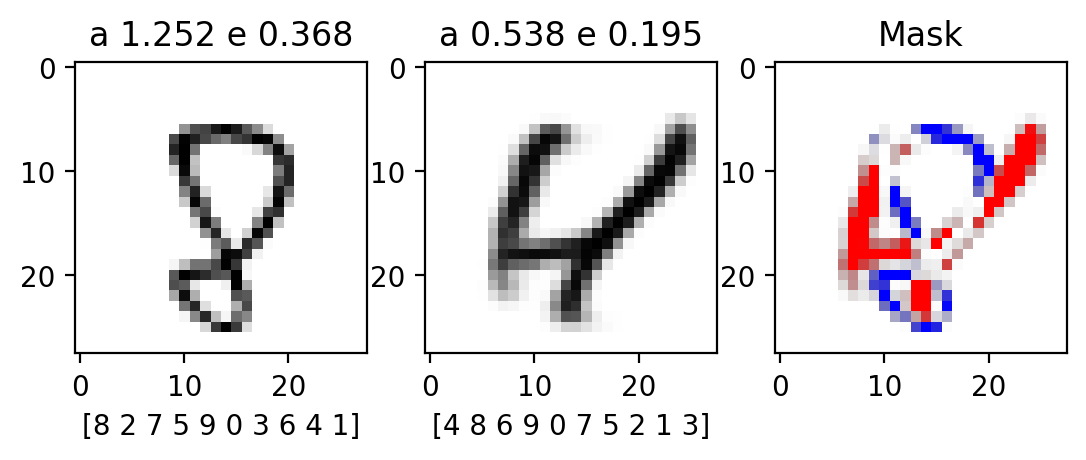

original aleatoric: 1.125 epistemic 0.482
original predictions [[2 9 8 3 4 7 0 5 6 1]]
explanation aleatoric: 0.177 epistemic 0.065
original predictions [[2 7 3 8 0 9 1 5 6 4]]
27


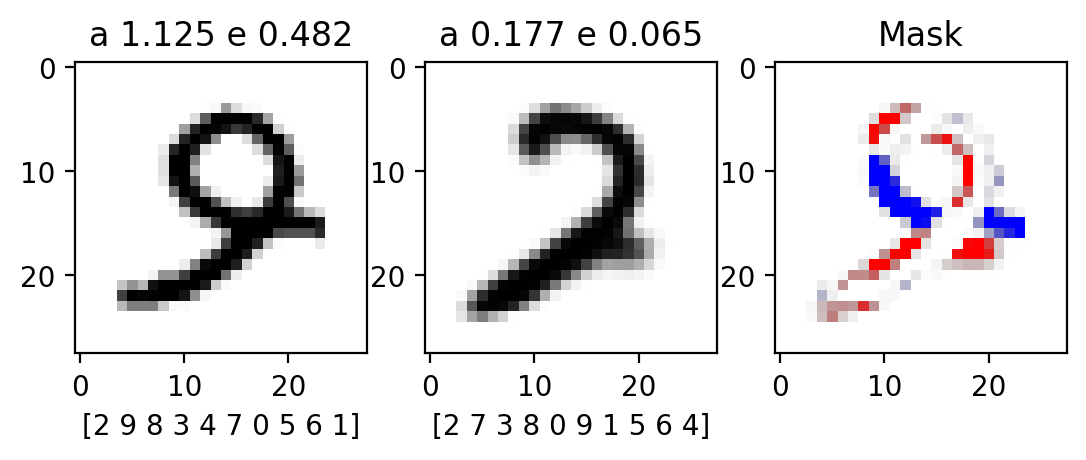

original aleatoric: 1.184 epistemic 0.424
original predictions [[9 8 5 3 0 2 7 1 6 4]]
explanation aleatoric: 0.920 epistemic 0.352
original predictions [[6 0 9 4 8 2 7 5 1 3]]
28


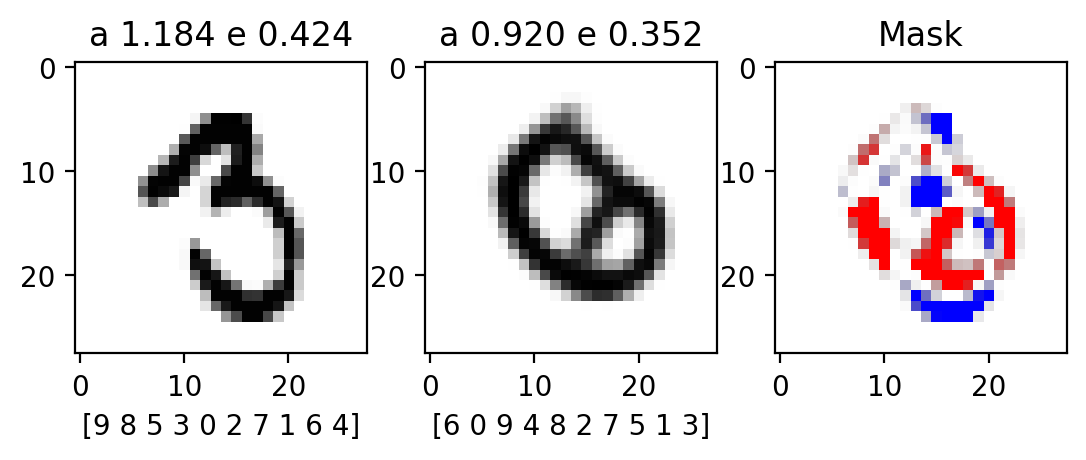

original aleatoric: 1.278 epistemic 0.327
original predictions [[0 8 2 6 5 9 4 1 3 7]]
explanation aleatoric: 0.075 epistemic 0.032
original predictions [[4 6 9 5 2 7 8 0 1 3]]
29


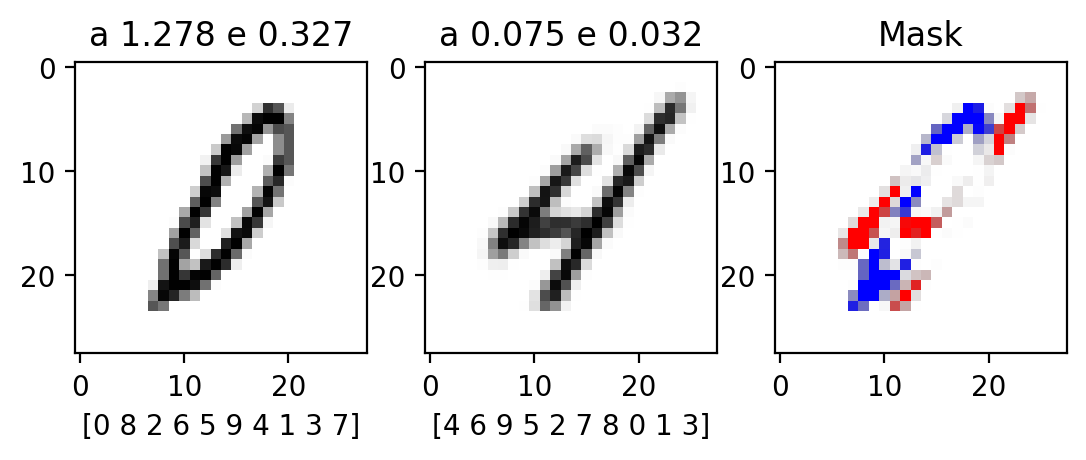

original aleatoric: 1.027 epistemic 0.578
original predictions [[9 0 5 8 3 2 4 6 7 1]]
explanation aleatoric: 0.834 epistemic 0.423
original predictions [[3 5 9 8 2 7 0 4 6 1]]
30


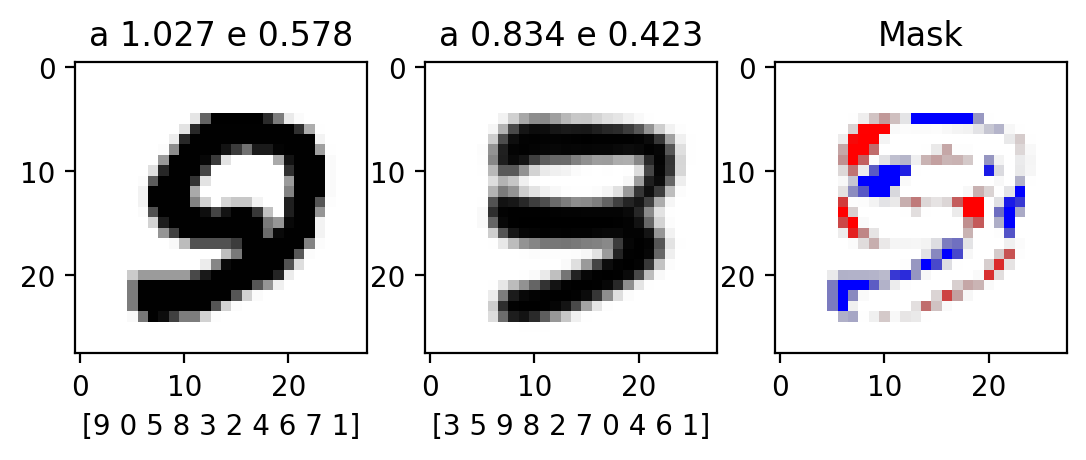

original aleatoric: 1.247 epistemic 0.357
original predictions [[9 7 2 3 5 4 6 8 1 0]]
explanation aleatoric: 0.918 epistemic 0.262
original predictions [[9 2 4 7 5 3 8 0 6 1]]
31


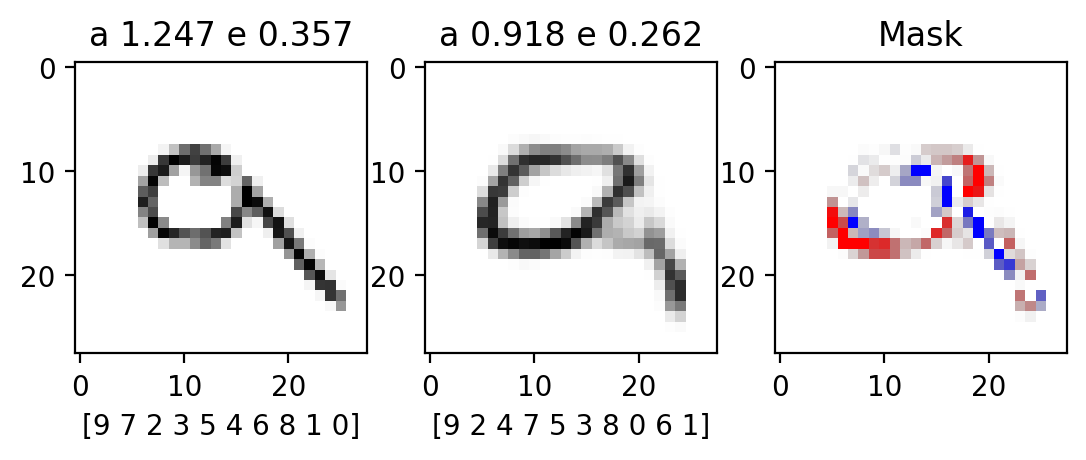

original aleatoric: 1.259 epistemic 0.341
original predictions [[8 9 3 5 2 7 4 1 6 0]]
explanation aleatoric: 0.925 epistemic 0.212
original predictions [[8 9 5 3 4 7 2 6 1 0]]
32


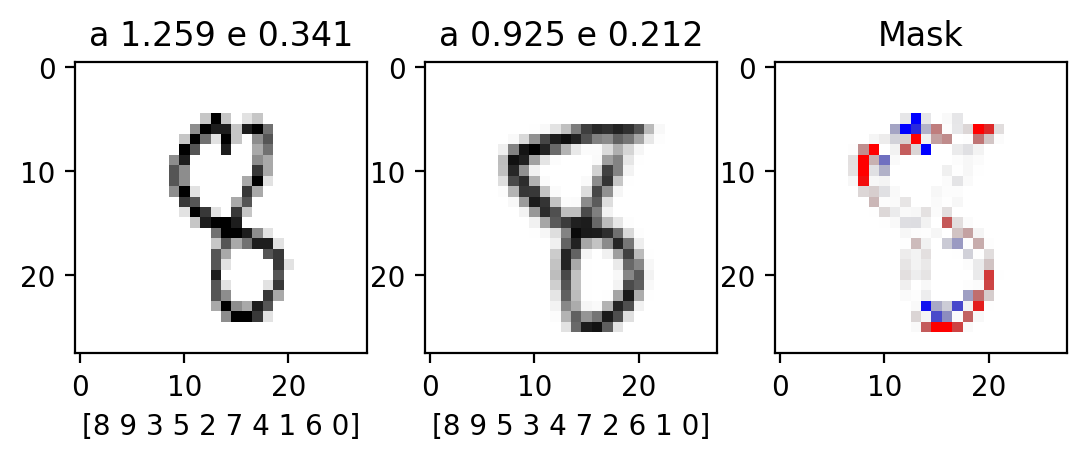

original aleatoric: 1.134 epistemic 0.463
original predictions [[3 0 5 8 2 6 9 7 1 4]]
explanation aleatoric: 1.085 epistemic 0.382
original predictions [[2 3 6 1 8 0 5 4 9 7]]
33


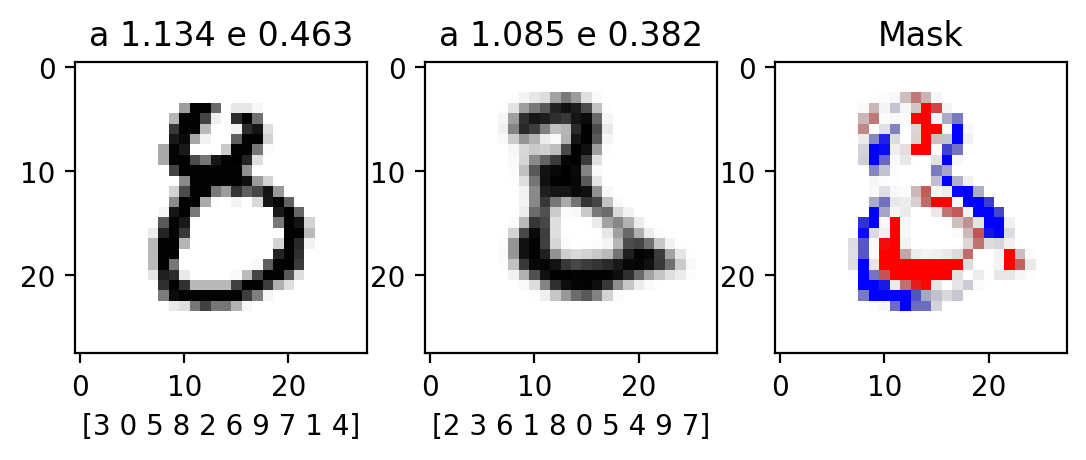

original aleatoric: 1.149 epistemic 0.447
original predictions [[3 8 1 7 2 5 0 9 4 6]]
explanation aleatoric: 0.282 epistemic 0.084
original predictions [[8 3 9 5 7 2 1 4 0 6]]
34


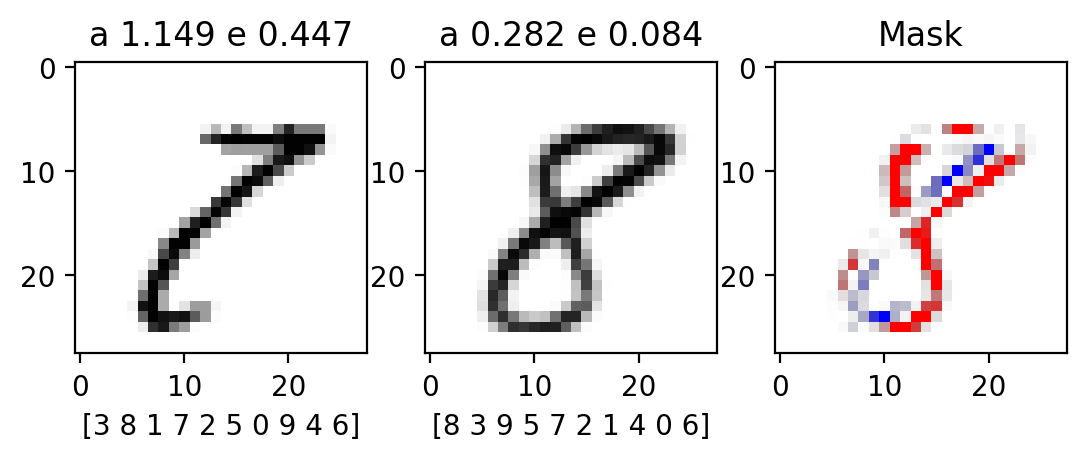

original aleatoric: 1.227 epistemic 0.367
original predictions [[5 9 3 4 8 7 0 6 2 1]]
explanation aleatoric: 0.291 epistemic 0.067
original predictions [[8 4 5 9 3 7 6 1 2 0]]
35


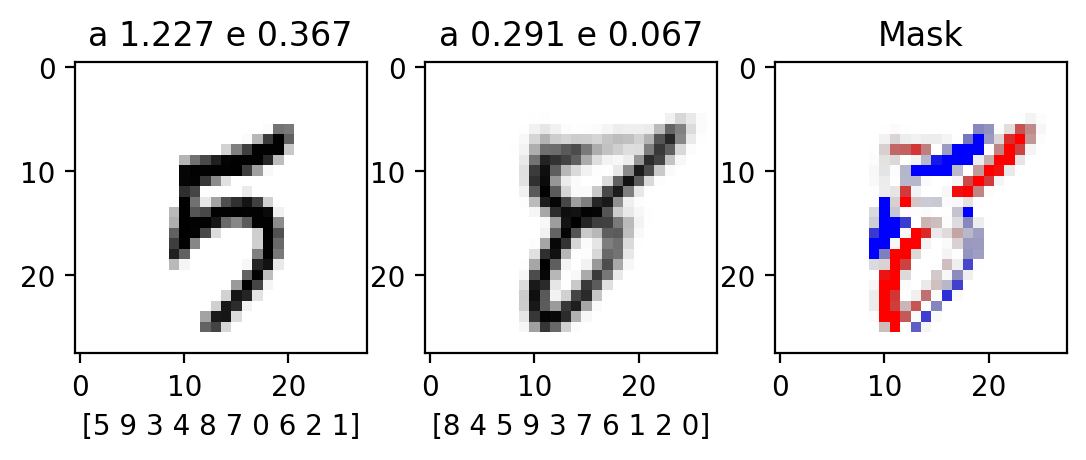

original aleatoric: 1.170 epistemic 0.423
original predictions [[3 2 0 4 9 7 8 5 1 6]]
explanation aleatoric: 0.373 epistemic 0.129
original predictions [[3 9 8 2 5 0 4 7 1 6]]
36


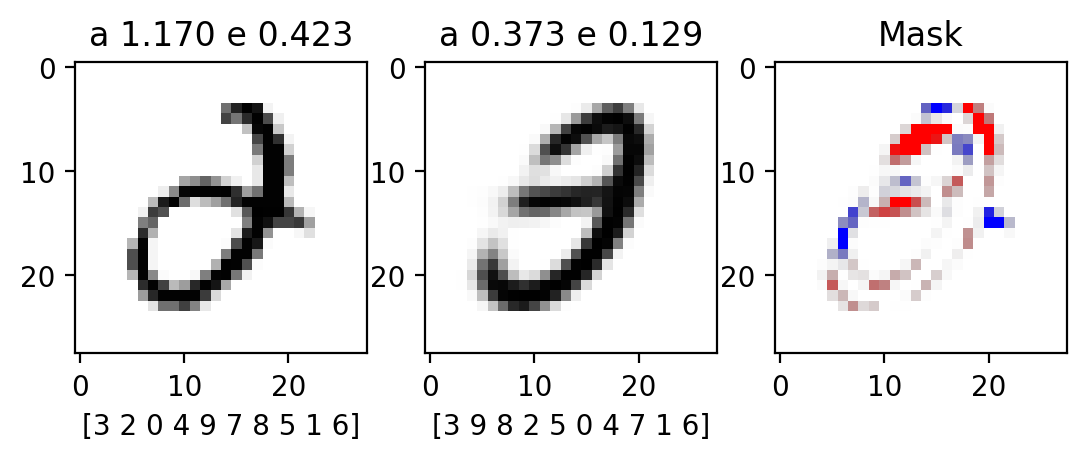

original aleatoric: 1.192 epistemic 0.400
original predictions [[4 9 7 1 8 5 3 0 6 2]]
explanation aleatoric: 0.381 epistemic 0.105
original predictions [[9 4 7 8 5 3 0 1 6 2]]
37


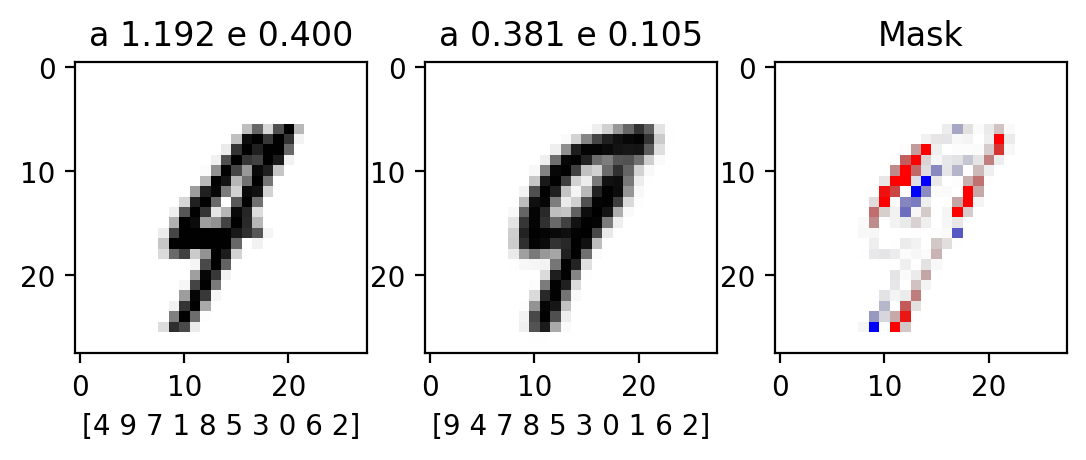

original aleatoric: 1.198 epistemic 0.393
original predictions [[2 8 6 1 5 4 0 9 7 3]]
explanation aleatoric: 1.017 epistemic 0.276
original predictions [[6 8 2 4 5 1 0 9 3 7]]
38


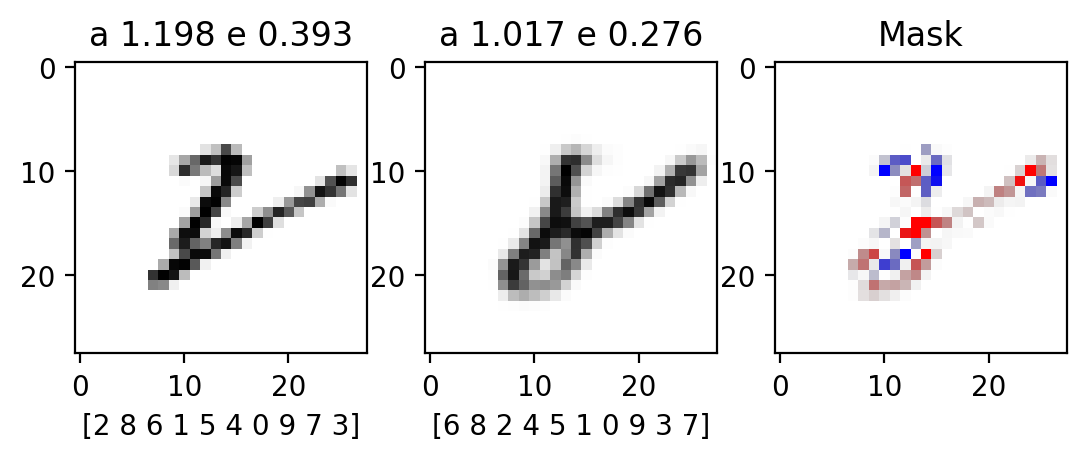

original aleatoric: 1.207 epistemic 0.378
original predictions [[2 7 1 8 3 9 4 0 6 5]]
explanation aleatoric: 1.203 epistemic 0.359
original predictions [[2 8 1 3 7 9 0 4 5 6]]
39


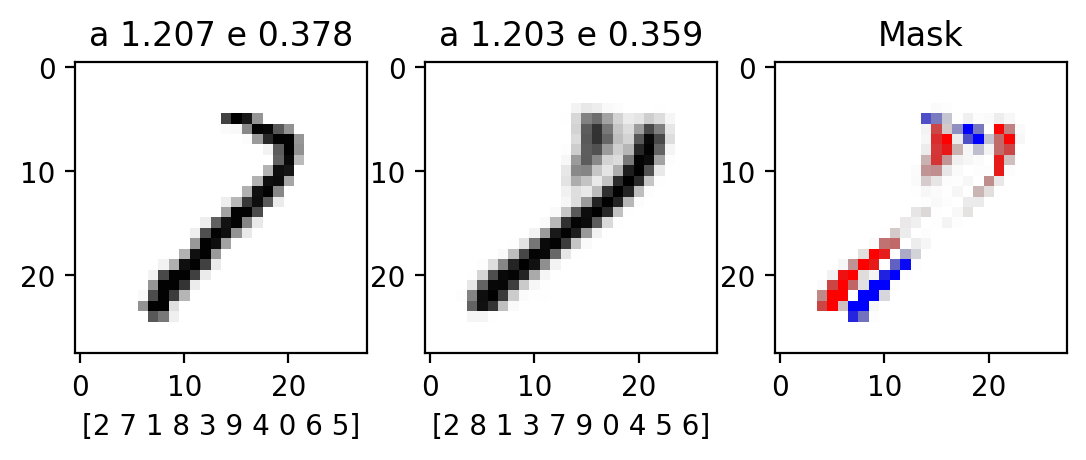

In [36]:

from src.probability import decompose_entropy_cat
from src.utils import MNIST_mean_std_norm


o_uncert_tosave = []
o_class_tosave = []
post_uncert_tosave = []
post_class_tosave = []
x_start_tosave = []
x_end_tosave = []


for N_explain in range(Nbatch):

    to_BNN = MNIST_mean_std_norm(torch.tensor(x_test[uncert_idxs_sorted[N_explain],0,:,:]).view(1,-1)).to(BNN.device)
    probs = BNN.sample_predict(to_BNN, Nsamples=0, grad=False)
    o_total_entropy, o_aleatoric_entropy, o_epistemic_entropy = decompose_entropy_cat(probs)
    print('original aleatoric: %2.3f epistemic %2.3f' % (o_aleatoric_entropy.item(), o_epistemic_entropy.item()))
    _, o_preds = probs.mean(dim=0).sort(dim=1, descending=True)
    print('original predictions', o_preds.cpu().numpy())


    fig, ax = plt.subplots(nrows=1, ncols=3, dpi=200)
    ax[0].imshow(1-x_test[uncert_idxs_sorted[N_explain],0,:,:], cmap='gray')
    ax[0].set_title('a %2.3f e %2.3f' % (o_aleatoric_entropy.item(), o_epistemic_entropy.item()))
    ax[0].set_xlabel(o_preds.cpu().numpy()[0])


    to_BNN = MNIST_mean_std_norm(torch.tensor(x_vec[-1,N_explain,0,:,:]).view(1,-1)).to(BNN.device)
    probs = BNN.sample_predict(to_BNN, Nsamples=0, grad=False)
    total_entropy, aleatoric_entropy, epistemic_entropy = decompose_entropy_cat(probs)
    print('explanation aleatoric: %2.3f epistemic %2.3f' % (aleatoric_entropy.item(), epistemic_entropy.item()))
    _, preds = probs.mean(dim=0).sort(dim=1, descending=True)
    print('original predictions', preds.cpu().numpy())


    ax[1].imshow(1-x_vec[-1,N_explain,0,:,:], cmap='gray')
    ax[1].set_title('a %2.3f e %2.3f' % (aleatoric_entropy.item(), epistemic_entropy.item()))
    ax[1].set_xlabel(preds.cpu().numpy()[0])

    mask = x_vec[-1] - x_init_batch

    mask_neg = -mask[N_explain,0,:,:]
    mask_neg[mask_neg < 1e-3] = 0
    mask_neg = (mask_neg**2)
    mask_neg = np.repeat(np.expand_dims(mask_neg, axis=2), 4, axis=2)*2
    mask_neg[:,:,0:2] = 0

    mask_pos = mask[N_explain,0,:,:]
    mask_pos[mask_pos < 1e-3] = 0
    mask_pos = mask_pos**2
    mask_pos = np.repeat(np.expand_dims(mask_pos, axis=2), 4, axis=2)*2
    mask_pos[:,:,1:3] = 0


    # ax[2].imshow(1-x_init_batch[N_explain, 0,:,:], cmap='gray')
    ax[2].imshow(mask_pos, alpha=1)#,  vmin=0, vmax=1)
    ax[2].imshow(mask_neg, alpha=1)
    ax[2].set_title('Mask')

    print(N_explain)
    plt.show()

    o_uncert_tosave.append(o_total_entropy.data.cpu().numpy())
    o_class_tosave.append(o_preds.data.cpu().numpy())
    post_uncert_tosave.append(total_entropy.data.cpu().numpy())
    post_class_tosave.append(preds.data.cpu().numpy())
    x_start_tosave.append(x_test[uncert_idxs_sorted[N_explain],0,:,:])
    x_end_tosave.append(x_vec[-1,N_explain,0,:,:])


o_uncert_tosave = np.stack(o_uncert_tosave, axis=0)
o_class_tosave = np.stack(o_class_tosave, axis=0)
post_uncert_tosave = np.stack(post_uncert_tosave, axis=0)
post_class_tosave = np.stack(post_class_tosave, axis=0)
x_start_tosave = np.stack(x_start_tosave, axis=0)
x_end_tosave = np.stack(x_end_tosave, axis=0)




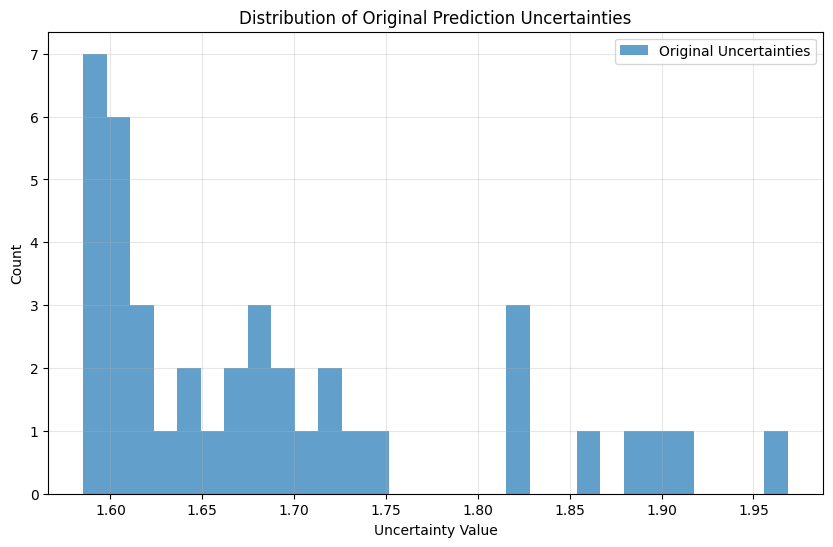

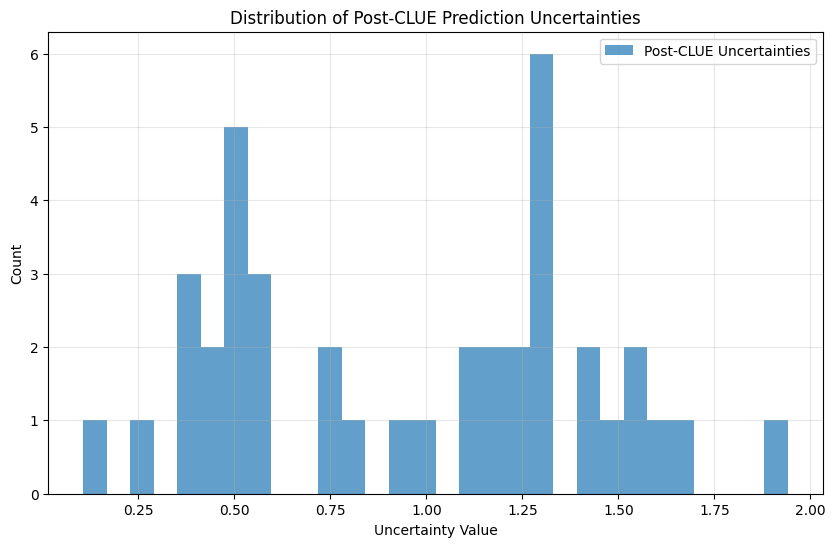

In [37]:
plt.figure(figsize=(10,6))
plt.hist(o_uncert_tosave, bins=30, alpha=0.7, label='Original Uncertainties')
plt.xlabel('Uncertainty Value')
plt.ylabel('Count')
plt.title('Distribution of Original Prediction Uncertainties')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,6))
plt.hist(post_uncert_tosave, bins=30, alpha=0.7, label='Post-CLUE Uncertainties')
plt.xlabel('Uncertainty Value')
plt.ylabel('Count')
plt.title('Distribution of Post-CLUE Prediction Uncertainties')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [38]:
def visualize_latent_trajectory(VAE, z_vec, sample_idx=0, num_steps=None, figsize=(15,6)):
    """
    Visualize the trajectory of latent points for a single sample.

    Args:
        VAE: The trained VAE model
        z_vec: Trajectory of latent vectors (steps × batch_size × latent_dim)
        sample_idx: Which sample to visualize (default=0)
        num_steps: Number of steps to visualize (default=None, shows all)
        figsize: Size of the figure (default=(15,6))
    """
    # Get trajectory for specific sample
    z_trajectory = z_vec[:, sample_idx, :]
    total_steps = len(z_trajectory)

    # If num_steps specified, select evenly spaced steps
    if num_steps is not None:
        indices = np.linspace(0, total_steps-1, num_steps, dtype=int)
        z_trajectory = z_trajectory[indices]

    # Convert to tensor if necessary
    if isinstance(z_trajectory, np.ndarray):
        z_trajectory = torch.from_numpy(z_trajectory).float()

    # Calculate grid dimensions
    num_points = len(z_trajectory)
    num_rows = (num_points - 1) // 5 + 1  # 5 images per row
    num_cols = min(5, num_points)  # Maximum of 5 columns

    # Generate images from the latent vectors
    with torch.no_grad():
        x_rec = VAE.model.decode(z_trajectory.to(VAE.device))
        x_rec = torch.sigmoid(x_rec)

    # Plot the generated images
    plt.figure(figsize=figsize)
    for i in range(num_points):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(x_rec[i].detach().cpu().reshape(28,28), cmap='gray')
        plt.axis('off')
        if num_steps is not None:
            step_num = indices[i]
        else:
            step_num = i
        plt.title(f'Step {step_num}\n{"Initial" if step_num == 0 else "Final" if step_num == total_steps-1 else ""}')

    plt.suptitle(f'Latent Space Trajectory for Sample {sample_idx}')
    plt.tight_layout()
    plt.show()

# Example usage:
# Show all steps:
# visualize_latent_trajectory(VAE, z_vec, sample_idx=0)

# Or show specific number of evenly-spaced steps:
# visualize_latent_trajectory(VAE, z_vec, sample_idx=0, num_steps=10)

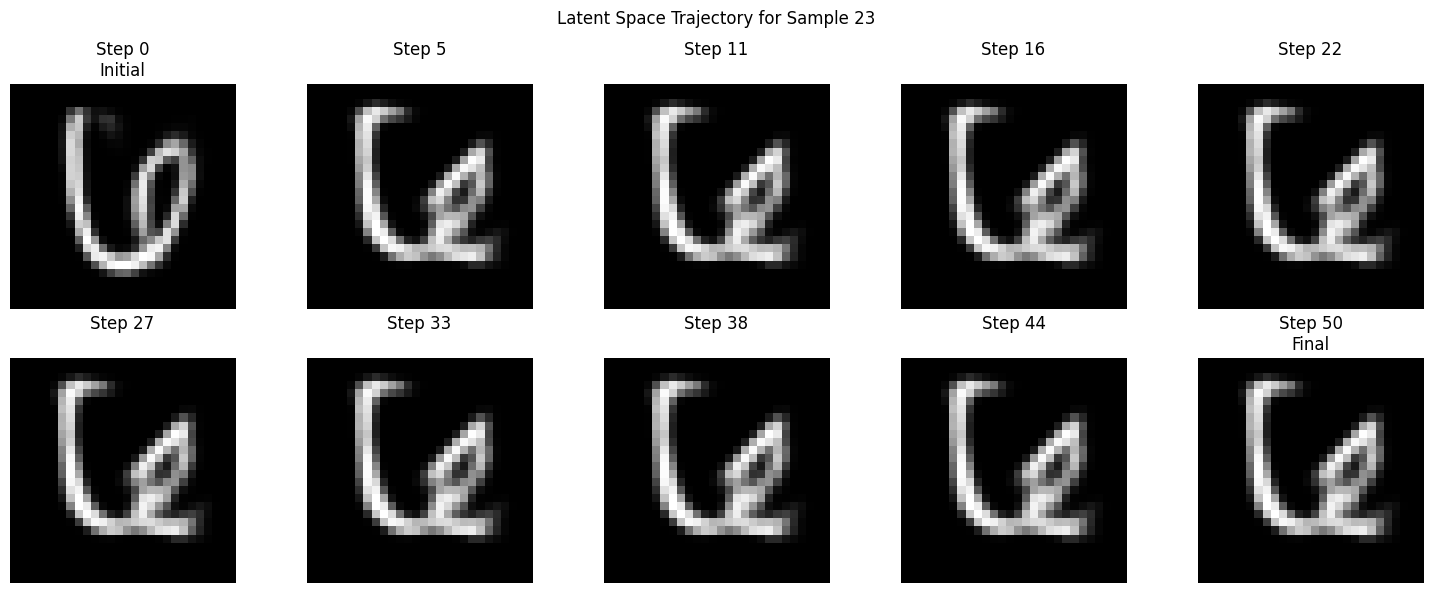

In [45]:
visualize_latent_trajectory(VAE, z_vec, sample_idx=23, num_steps = 10)

In [46]:
def visualize_trajectory_with_original(VAE, z_vec, x_vec, sample_idx=0, num_steps=None, figsize=(15,8)):
    """
    Visualize the trajectory with the original input image.
    """
    plt.figure(figsize=figsize)

    # Plot original image
    plt.subplot(2, 1, 1)
    plt.imshow(x_vec[sample_idx].reshape(28,28), cmap='gray')
    plt.title('Original Input')
    plt.axis('off')

    # Plot trajectory
    plt.subplot(2, 1, 2)
    visualize_latent_trajectory(VAE, z_vec, sample_idx, num_steps)
    plt.show()

# Example usage:
# visualize_trajectory_with_original(VAE, z_vec, original_x, sample_idx=0, num_steps=10)

In [47]:
def visualize_x_trajectory(CLUE_explainer, x_vec, sample_idx=0, num_steps=None, figsize=(15,8)):
    """
    Visualize the image trajectory with the original input image.

    Args:
        CLUE_explainer: The CLUE model instance containing original_x
        x_vec: Trajectory of images (steps × batch_size × image_dimensions)
        sample_idx: Which sample to visualize (default=0)
        num_steps: Number of steps to visualize (default=None, shows all)
        figsize: Size of the figure (default=(15,8))
    """
    # Get the original input from CLUE model
    original_x = CLUE_explainer.original_x.cpu().numpy()

    # Get trajectory for specific sample
    x_trajectory = x_vec[:, sample_idx]
    total_steps = len(x_trajectory)

    # If num_steps specified, select evenly spaced steps
    if num_steps is not None:
        indices = np.linspace(0, total_steps-1, num_steps, dtype=int)
        x_trajectory = x_trajectory[indices]
    else:
        indices = range(total_steps)

    # Calculate grid dimensions for trajectory
    num_points = len(x_trajectory)
    num_rows = (num_points - 1) // 5 + 1  # 5 images per row
    num_cols = min(5, num_points)  # Maximum of 5 columns

    plt.figure(figsize=figsize)

    # Plot original image
    plt.subplot(num_rows + 1, num_cols, 1)
    plt.imshow(original_x[sample_idx].reshape(28,28), cmap='gray')
    plt.title('Original Input')
    plt.axis('off')

    # Plot trajectory
    for i in range(num_points):
        plt.subplot(num_rows + 1, num_cols, num_cols + i + 1)
        plt.imshow(x_trajectory[i].reshape(28,28), cmap='gray')
        plt.axis('off')
        step_num = indices[i]
        plt.title(f'Step {step_num}\n{"Initial" if step_num == 0 else "Final" if step_num == total_steps-1 else ""}')

    plt.suptitle(f'Image Trajectory for Sample {sample_idx}')
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_x_trajectory(CLUE_explainer, x_vec, sample_idx=0, num_steps=10)

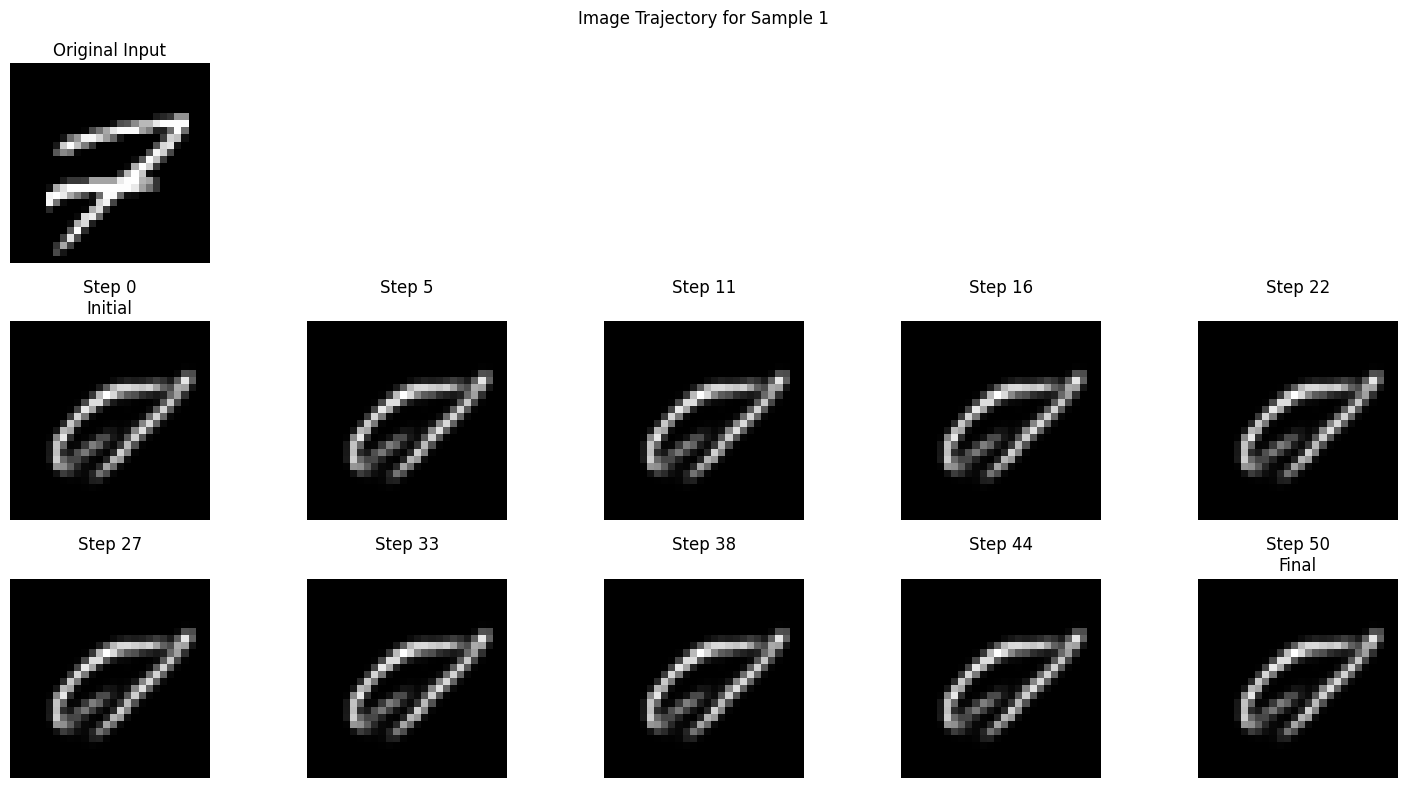

In [48]:
visualize_x_trajectory(CLUE_explainer, x_vec, sample_idx=1, num_steps=10)

Using device: cuda


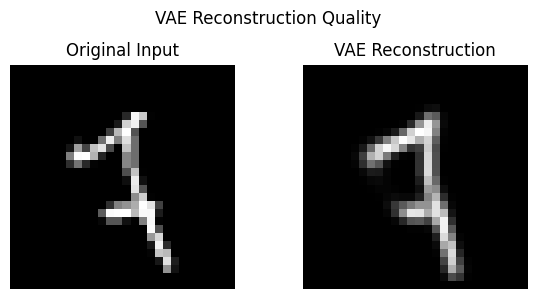

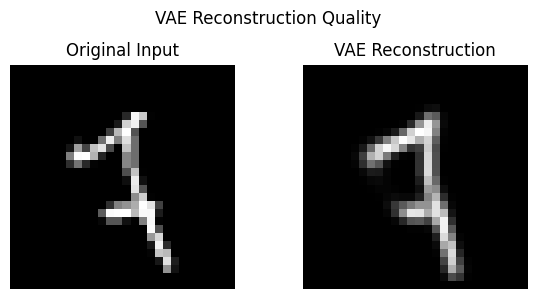

Step 1/50
Step 2/50
Step 3/50
Step 4/50
Step 5/50
Step 6/50
Step 7/50
Step 8/50
Step 9/50
Step 10/50
Step 11/50
Step 12/50
Step 13/50
Step 14/50
Step 15/50
Step 16/50
Step 17/50
Step 18/50
Step 19/50
Step 20/50
Step 21/50
Step 22/50
Step 23/50
Step 24/50
Step 25/50
Step 26/50
Step 27/50
Step 28/50
Step 29/50
Step 30/50
Step 31/50
Step 32/50
Step 33/50
Step 34/50
Step 35/50
Step 36/50
Step 37/50
Step 38/50
Step 39/50
Step 40/50
Step 41/50
Step 42/50
Step 43/50
Step 44/50
Step 45/50
Step 46/50
Step 47/50
Step 48/50
Step 49/50
Step 50/50


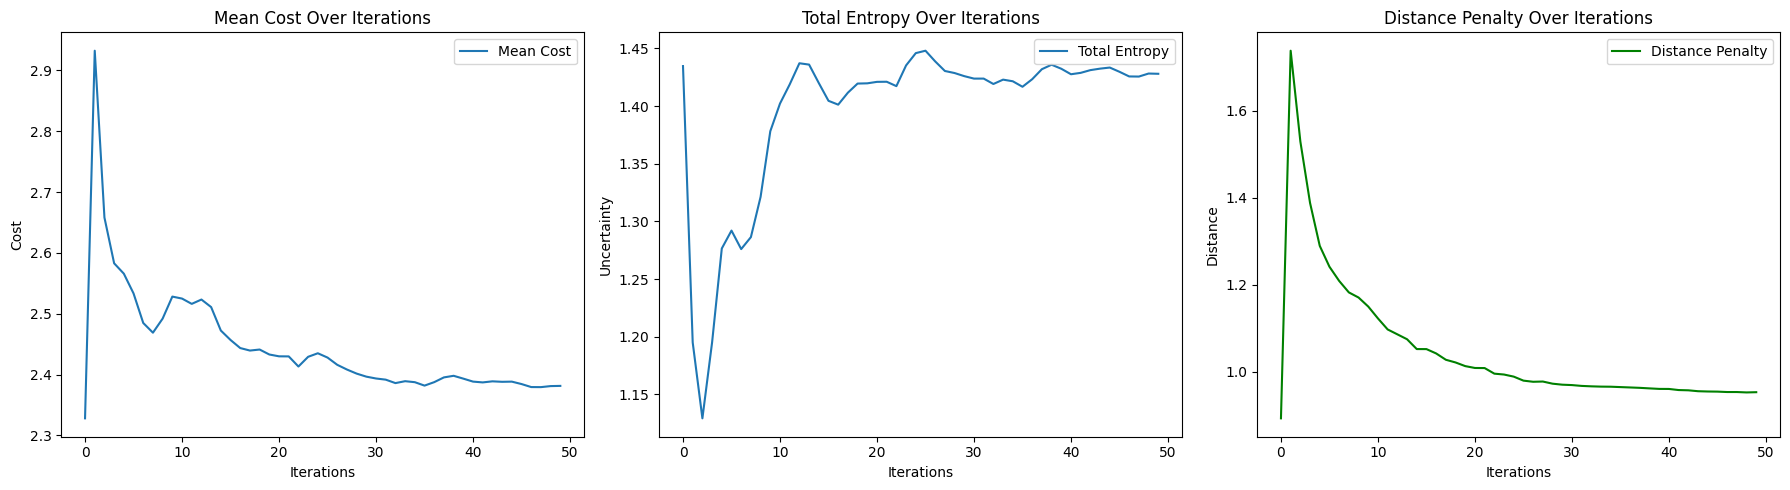

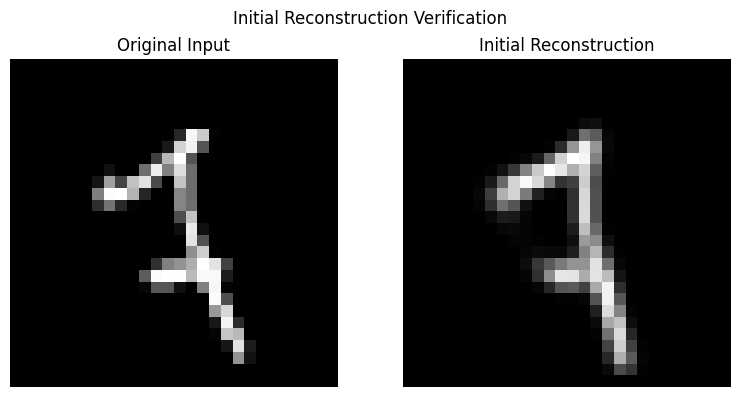

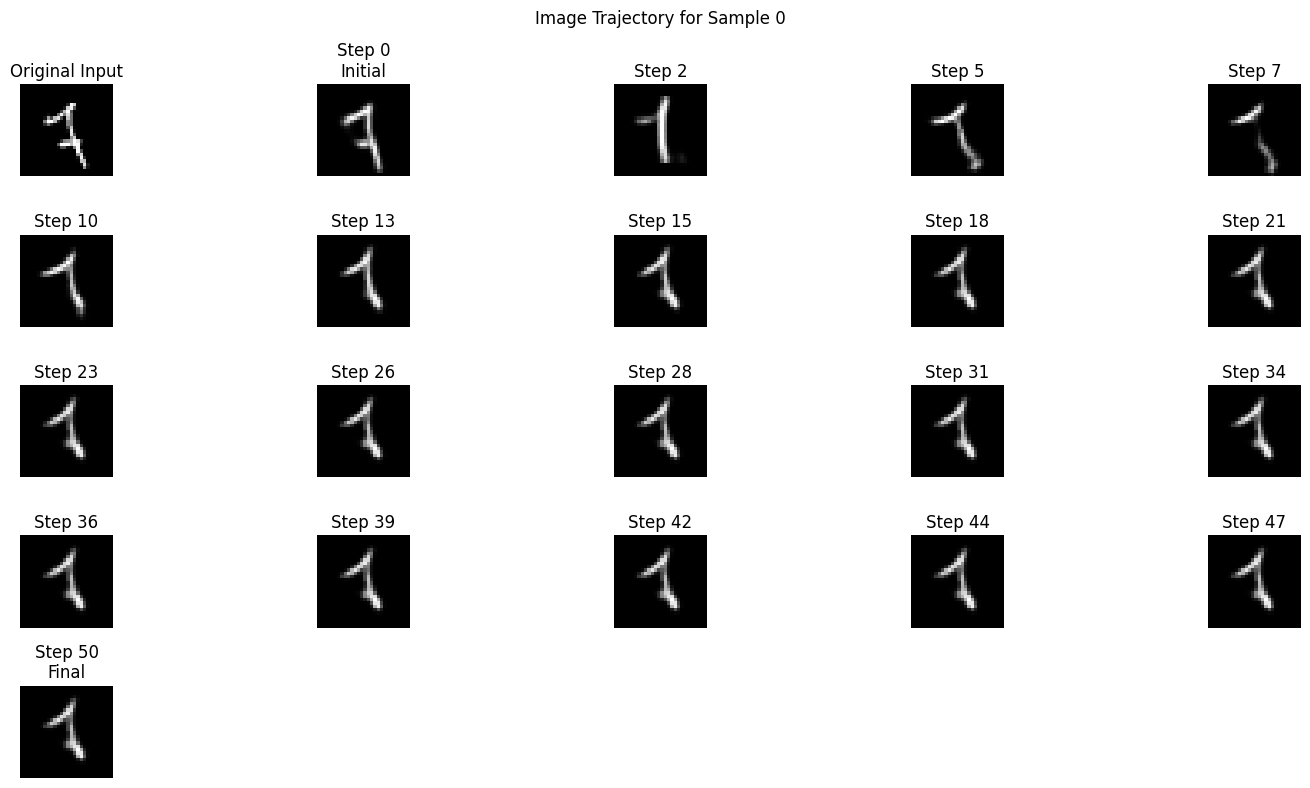

In [ ]:
# /Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/my-experiments/test-CLUE.ipynb

import importlib
import interpret.CLUE
importlib.reload(interpret.CLUE)
from interpret.CLUE import CLUE
from src.utils import Ln_distance
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure the device is correctly set
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Clear CUDA cache if using CUDA
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Define distance metric
dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]
distance_weight = 25 / x_dim

# Step 1: Test VAE Reconstruction Quality
def test_vae_reconstruction(VAE, original_x, sample_idx=0):
    """Test VAE reconstruction quality."""
    VAE.model.eval()

    # Convert original_x to a PyTorch tensor if it's a NumPy array
    if isinstance(original_x, np.ndarray):
        original_x = torch.from_numpy(original_x).float()

    with torch.no_grad():
        # Encode
        approx_post = VAE.model.encode(original_x.to(device))
        if hasattr(approx_post, 'loc'):
            z = approx_post.loc  # For models returning distributions
        else:
            z = approx_post  # For deterministic encoders

        # Decode
        x_rec = VAE.model.decode(z)
        x_rec = torch.sigmoid(x_rec)  # Assuming Bernoulli VAE

    # Visualize original and reconstruction
    plt.figure(figsize=(6,3))

    plt.subplot(1,2,1)
    plt.imshow(original_x[sample_idx].cpu().reshape(28,28), cmap='gray')
    plt.title('Original Input')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(x_rec[sample_idx].cpu().reshape(28,28), cmap='gray')
    plt.title('VAE Reconstruction')
    plt.axis('off')

    plt.suptitle('VAE Reconstruction Quality')
    plt.tight_layout()
    plt.show()

    return z.cpu().numpy()

# Run the VAE reconstruction test
z_init_from_vae = test_vae_reconstruction(VAE, x_init_batch, sample_idx=0)
# Run the VAE reconstruction test
z_init_from_vae = test_vae_reconstruction(VAE, x_init_batch, sample_idx=0)

# Step 2: Initialize CLUE with the Correct Latent Representation
CLUE_explainer = CLUE(
    VAE=VAE,
    BNN=BNN,
    original_x=x_init_batch,
    uncertainty_weight=1,
    aleatoric_weight=0,
    epistemic_weight=0,
    prior_weight=0,
    distance_weight=distance_weight,
    latent_L2_weight=0,
    prediction_similarity_weight=0,
    lr=0.5,  # Adjusted learning rate for better optimization progress
    cond_mask=None,
    distance_metric=dist,
    z_init=z_init_from_vae,  # Use the encoded latent representation
    norm_MNIST=True,
    flatten_BNN=True,
    regression=False,
    prob_BNN=True,
    cuda=(device.type == 'cuda')
)

# Move CLUE's internal tensors to the correct device
CLUE_explainer.to(device)

# Step 3: Verify Initial Reconstructions Match Original Inputs
def verify_initial_reconstruction(CLUE_explainer, VAE, x_vec, sample_idx=0):
    """Verify that the initial step matches the original input."""
    initial_rec = x_vec[0, sample_idx].reshape(28, 28)
    original = CLUE_explainer.original_x[sample_idx].cpu().reshape(28, 28)

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Input')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(initial_rec, cmap='gray')
    plt.title('Initial Reconstruction')
    plt.axis('off')

    plt.suptitle('Initial Reconstruction Verification')
    plt.tight_layout()
    plt.show()

# Run CLUE optimization with anomaly detection and monitoring
torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection for debugging

def run_clue_with_diagnostics(CLUE_explainer, min_steps=3, max_steps=50, n_early_stop=20):
         """Run CLUE optimization with detailed diagnostics."""
         # Initialize lists to store trajectories
         z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = \
             CLUE_explainer.optimise(min_steps=min_steps, max_steps=max_steps, n_early_stop=n_early_stop)

         # Convert to numpy for easier handling
         z_vec_np = np.array(z_vec)
         x_vec_np = np.array(x_vec)
         uncertainty_vec_np = np.array(uncertainty_vec)
         epistemic_vec_np = np.array(epistemic_vec)
         aleatoric_vec_np = np.array(aleatoric_vec)
         cost_vec_np = np.array(cost_vec)
         dist_vec_np = np.array(dist_vec)

         # Plot optimization metrics
         fig, axes = plt.subplots(1, 3, figsize=(18,5))

         axes[0].plot(cost_vec_np.mean(axis=1), label='Mean Cost')
         axes[0].set_title('Mean Cost Over Iterations')
         axes[0].set_xlabel('Iterations')
         axes[0].set_ylabel('Cost')
         axes[0].legend()

         axes[1].plot(uncertainty_vec_np.mean(axis=1), label='Total Entropy')
         axes[1].set_title('Total Entropy Over Iterations')
         axes[1].set_xlabel('Iterations')
         axes[1].set_ylabel('Uncertainty')
         axes[1].legend()

         axes[2].plot(dist_vec_np.mean(axis=1), label='Distance Penalty', color='green')
         axes[2].set_title('Distance Penalty Over Iterations')
         axes[2].set_xlabel('Iterations')
         axes[2].set_ylabel('Distance')
         axes[2].legend()

         plt.tight_layout()
         plt.show()

         # Verify initial reconstruction
         verify_initial_reconstruction(CLUE_explainer, VAE, x_vec_np, sample_idx=0)

         # Visualize trajectory for the first sample
         visualize_x_trajectory(x_vec_np, CLUE_explainer.original_x, sample_idx=0, num_steps=20)

         return z_vec_np, x_vec_np, uncertainty_vec_np, epistemic_vec_np, aleatoric_vec_np, cost_vec_np, dist_vec_np

def visualize_x_trajectory(x_vec, original_x, sample_idx=0, num_steps=20, figsize=(15,8)):
  """
  Visualize the image trajectory with the original input image.

  Args:
      x_vec: Trajectory of images (steps × batch_size × image_dimensions)
      original_x: Original input images
      sample_idx: Which sample to visualize (default=0)
      num_steps: Number of steps to visualize (default=20)
      figsize: Size of the figure (default=(15,8))
  """
  # Get trajectory for specific sample
  x_trajectory = x_vec[:, sample_idx]
  total_steps = len(x_trajectory)

  # If num_steps specified and less than total_steps, select evenly spaced steps
  if num_steps is not None and total_steps > num_steps:
      indices = np.linspace(0, total_steps-1, num_steps, dtype=int)
      x_trajectory = x_trajectory[indices]
  else:
      indices = range(total_steps)

  # Calculate grid dimensions for trajectory
  num_points = len(x_trajectory) + 1  # +1 for original image
  num_cols = 5
  num_rows = (num_points + num_cols - 1) // num_cols  # Ceiling division to ensure enough rows

  plt.figure(figsize=figsize)

  # Plot original image
  plt.subplot(num_rows, num_cols, 1)
  plt.imshow(original_x[sample_idx].cpu().reshape(28,28), cmap='gray')
  plt.title('Original Input')
  plt.axis('off')

  # Plot trajectory
  for i in range(len(x_trajectory)):
      plt.subplot(num_rows, num_cols, i+2)  # +2 to account for original image
      plt.imshow(x_trajectory[i].reshape(28,28), cmap='gray')
      plt.axis('off')
      step_num = indices[i]
      if step_num == 0:
          plt.title(f'Step {step_num}\nInitial')
      elif step_num == total_steps-1:
          plt.title(f'Step {step_num}\nFinal')
      else:
          plt.title(f'Step {step_num}')

  plt.suptitle(f'Image Trajectory for Sample {sample_idx}')
  plt.tight_layout()
  plt.show()

# Example usage:
# visualize_x_trajectory(x_vec_np, CLUE_explainer.original_x, sample_idx=0, num_steps=20)

# Step 4: Execute Optimization with Diagnostics
z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = \
    run_clue_with_diagnostics(CLUE_explainer)

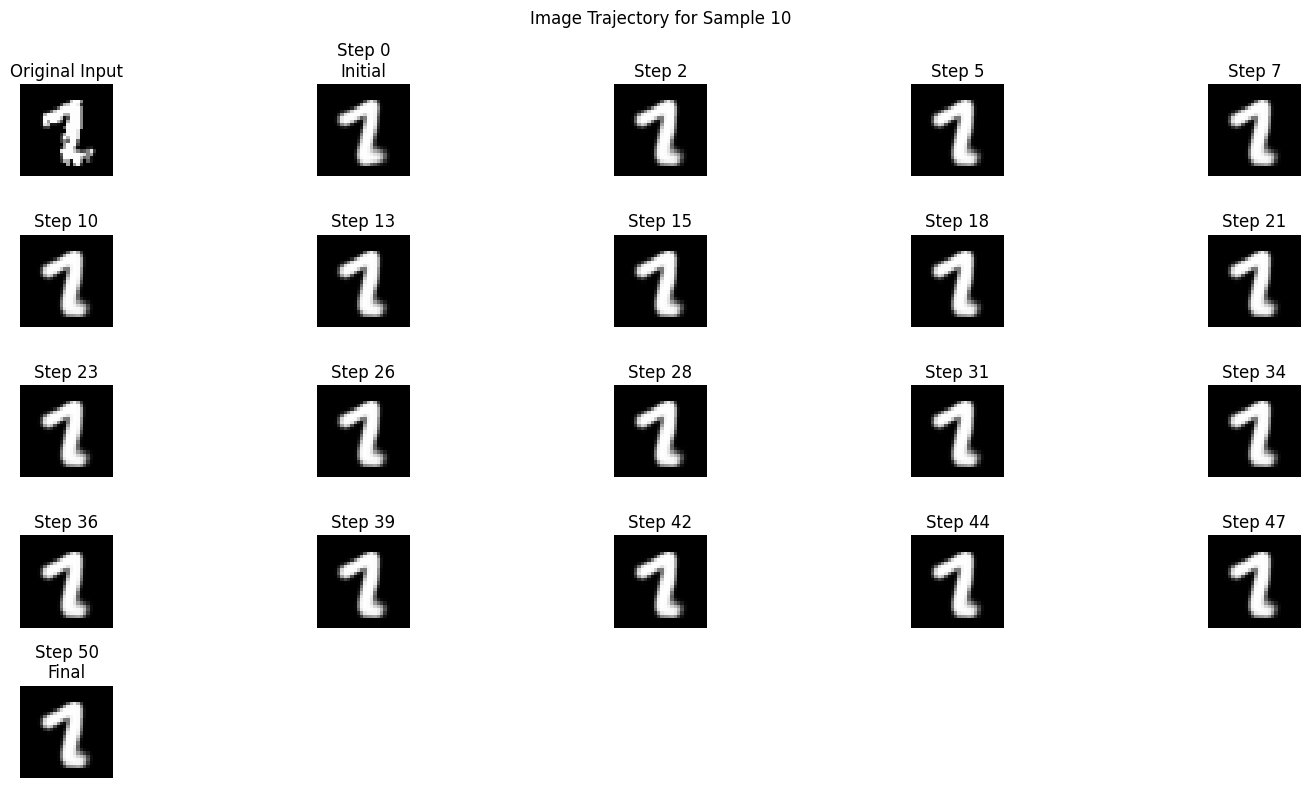

In [ ]:
visualize_x_trajectory(x_vec, CLUE_explainer.original_x, sample_idx=10, num_steps=20)